In [5]:
## Produce a complete and harmonised f2f dataset for major 'demographic' features

# step 1 - fill in the gaps in the variables already identified (vote/turnout/age/income/housing)

In [6]:
%%time
dataset_name = "W19_only"
df_list = []

%matplotlib inline 
%run f2f_header.py {dataset_name} {df_list}
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# # pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
# pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
# pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')
# del BES_Panel

Toggle code

Wall time: 3.35 s


In [12]:
BES_df_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_df_list.pickle", "rb" ) )
f2f_harmonised = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')
BES_label_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_label_list.pickle", "rb" ) )
demo_var_dict = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\demo_var_dict.pickle", "rb" ) )
var_type_dict_nonans = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\var_type_dict_nonans.pickle", "rb" ) )

In [355]:
# BUG blank labels
# 1974_feb
BES_label_list["1974_feb"]['studyid'] = 'studyid'
BES_label_list["1974_feb"]['series'] = 'series'

# 1974_oct
BES_label_list["1974_oct"]["studyid"] = 'studyid'
BES_label_list["1974_oct"]["respno"] = 'respno'
BES_label_list["1974_oct"]["cardno"] = 'cardno'
BES_label_list["1974_oct"]["series"] = 'series'
BES_label_list["1974_oct"]["oct503"] = 'oct503'
BES_label_list["1974_oct"]["oct504"] = 'oct504'
BES_label_list["1974_oct"]["oct505"] = 'oct505'
BES_label_list["1974_oct"]["oct506"] = 'oct506'
BES_label_list["1974_oct"]["oct507"] = 'oct507'

In [ ]:
simple_dict = {"LD":"LD","LIB":"LD","ALL":"LD","UKIP":"REFUK","BXP":"REFUK","BNP":"REFUK","VOTED":"DK","OTH":"DK","TY":"DK",
 "SD":"LD","REF":"REFUK","COM":"DK"}
bloc_dict = {"CON":"Right-Auth","REFUK":"Right-Auth",
             "LAB":"Left-Lib","LD":"Left-Lib","PC":"Left-Lib","SNP":"Left-Lib","GP":"Left-Lib",
             "DNV":"Neither","DK":np.nan}
turnout_dict = {"CON":"VOTED","REFUK":"VOTED",
             "LAB":"VOTED","LD":"VOTED","PC":"VOTED","SNP":"VOTED","GP":"VOTED",
             "DNV":"DNV","DK":np.nan,
             "LIB":"VOTED","ALL":"VOTED","UKIP":"VOTED","BXP":"VOTED","BNP":"VOTED","VOTED":"VOTED","OTH":"VOTED",
             "SD":"VOTED","REF":"VOTED","COM":"VOTED",
             "TY":"CNV",
               }



In [40]:
generic_cols = f2f_harmonised.columns

def full_form_birth_year(x):
    if pd.isnull(x):
        return np.nan
    elif x>60:
        return 1800 + x
    else:
        return 1900 + x
    
def rep_char(x):
    return x.replace('[', '{').replace(']', '}').replace('<', '{').replace('>', '}')

def replace_var_names(labels):
    varname_replace_dict = {}
    replace_char_dict = {"[":"{","]":"}"}
    for col in df_simp.columns:
        if np.any([x in col for x in generic_cols]) or (col =="Age"):
            # 'age' is a problem as a common word component
            varname_replace_dict[col] = rep_char(col)
            
        elif "|" not in col:
            varname_replace_dict[col] = rep_char(labels[col])
        elif len(col.split("|"))==2:
            varname_replace_dict[col] = rep_char(labels[col.split("|")[0]])\
                +"("+ rep_char(col.split("|")[1]) +")"
        if varname_replace_dict[col]=="":
            varname_replace_dict[col] = rep_char(col)
    return varname_replace_dict

def rep_char(x):
    return x.replace('[', '{').replace(']', '}').replace('<', '{').replace('>', '}')

def replace_var_names(labels,df_simp):
    varname_replace_dict = {}
    replace_char_dict = {"[":"{","]":"}"}
    for col in df_simp.columns:
        if np.any([x in col for x in generic_cols]) or (col =="Age"):
            # 'age' is a problem as a common word component
            varname_replace_dict[col] = rep_char(col)
            
        elif "|" not in col:
            varname_replace_dict[col] = rep_char(labels[col])
        elif len(col.split("|"))==2:
            varname_replace_dict[col] = rep_char(labels[col.split("|")[0]])\
                +"("+ rep_char(col.split("|")[1]) +")"
        if varname_replace_dict[col]=="":
            varname_replace_dict[col] = rep_char(col)
    return varname_replace_dict

def prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars = [],demo_var_only=True,
        multi_class_target=False,dummy_na=True):

    if demo_var_only:
        demo_vars = demo_var_dict[ge]
    else:
        demo_vars = list(BES_label_list[ge].keys())

#     labels = BES_label_list[ge]
    df = pd.concat([BES_df_list[ge],
                            f2f_harmonised[f2f_harmonised["dataset"]==ge][harm_vars]
                           ],axis=1)
    old_demo_vars = demo_vars.copy()
    demo_vars = demo_vars+harm_vars
    demo_vars = list(set(demo_vars).intersection(df.columns))
    if drop_vars:
        demo_vars = [x for x in demo_vars if x not in drop_vars]
        old_demo_vars = [x for x in old_demo_vars if x not in drop_vars]    

    df_simp = df[demo_vars].copy()

    df_simp[target_var] = df_simp[target_var].replace(target_var_replace_dict)
    # prep nominal and ordinal as categorical to be dummied
    old_demo_vars = [x for x in old_demo_vars if var_type_dict_nonans[ge][x] in ["nominal","ordinal"]]
    scale_vars = [x for x in old_demo_vars if var_type_dict_nonans[ge][x] in ["scale"]]
        
    if not multi_class_target:
        df_simp[target_var] = df_simp[target_var].replace(target_var_replace_dict)    
        df_simp[old_demo_vars] = df_simp[old_demo_vars].astype('category')    
        df_simp[scale_vars] = df_simp[scale_vars].astype('float')
        df_simp = pd.get_dummies(df_simp,prefix_sep='|',dummy_na=dummy_na).drop(target_var_drop_list,axis=1)
        if target_var+"|nan" in df_simp.columns:
            df_simp.loc[df_simp[target_var+"|nan"]==1,var_stub]=np.nan
            df_simp.drop(target_var+"|nan",axis=1,inplace=True,)
    else:
        old_demo_vars = [x for x in old_demo_vars if x !=target_var]
        scale_vars = [x for x in scale_vars if x !=target_var]   
        df_simp[old_demo_vars] = df_simp[old_demo_vars].astype('category')    
        df_simp[scale_vars] = df_simp[scale_vars].astype('float')        
        df_simp[target_var] = df_simp[target_var].astype('category')
        target_var_drop_list = [x for x in target_var_drop_list if x in df_simp[target_var].cat.categories]
        df_simp[target_var] = df_simp[target_var].cat.remove_categories(target_var_drop_list)        
        all_but_target = [x for x in df_simp.columns if x !=target_var]
        target_temp = df_simp[target_var].copy()
        df_simp = pd.get_dummies(df_simp[all_but_target],prefix_sep='|',dummy_na=dummy_na)
        df_simp[target_temp.name] = target_temp
        

    df_simp = df_simp.rename(columns = replace_var_names( BES_label_list[ge] , df_simp ))  
    

    Treatment = var_stub+"_"+ge

    var_list = [var_stub]
    var_stub_list = [var_stub,]
    if not multi_class_target:
        df_simp = df_simp.select_dtypes('number')
        df_simp = df_simp.astype('float')
#     mask = df_simp[var_stub].notnull() & df_simp["wt"].notnull()
    return df_simp


def prep_df(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars = [],demo_var_only=True,alg=None,
           multi_class_target=False,dummy_na=True):

    # drop drop_var variables from demo_var list
    if demo_var_only:
        demo_vars = demo_var_dict[ge]
    else:
        demo_vars = list(BES_label_list[ge].keys())
        

#     labels = BES_label_list[ge]
    df = pd.concat([BES_df_list[ge],
                            f2f_harmonised[f2f_harmonised["dataset"]==ge][harm_vars]
                           ],axis=1)

    
    old_demo_vars = demo_vars.copy()
    demo_vars = demo_vars+harm_vars
    demo_vars = list(set(demo_vars).intersection(df.columns))
    # drop vars after adding harm/dropping ones not present
    if drop_vars:
        demo_vars = [x for x in demo_vars if x not in drop_vars]    
        old_demo_vars = [x for x in old_demo_vars if x not in drop_vars]    

    df_simp = df[demo_vars].copy()



    # prep nominal and ordinal as categorical to be dummied
    old_demo_vars = [x for x in old_demo_vars if var_type_dict_nonans[ge][x] in ["nominal","ordinal"]]
    scale_vars = [x for x in old_demo_vars if var_type_dict_nonans[ge][x] in ["scale"]]
    
    if not multi_class_target:
        df_simp[target_var] = df_simp[target_var].replace(target_var_replace_dict)    
        df_simp[old_demo_vars] = df_simp[old_demo_vars].astype('category')    
        df_simp[scale_vars] = df_simp[scale_vars].astype('float')
        df_simp = pd.get_dummies(df_simp,prefix_sep='|',dummy_na=dummy_na).drop(target_var_drop_list,axis=1)
        if target_var+"|nan" in df_simp.columns:
            df_simp.loc[df_simp[target_var+"|nan"]==1,var_stub]=np.nan
            df_simp.drop(target_var+"|nan",axis=1,inplace=True,)
        eval_metric='rmse'
    else:
        old_demo_vars = [x for x in old_demo_vars if x !=target_var]
        scale_vars = [x for x in scale_vars if x !=target_var]
        df_simp[old_demo_vars] = df_simp[old_demo_vars].astype('category')    
        df_simp[scale_vars] = df_simp[scale_vars].astype('float')
        df_simp[target_var] = df_simp[target_var].astype('category')
        target_var_drop_list = [x for x in target_var_drop_list if x in df_simp[target_var].cat.categories]
        df_simp[target_var] = df_simp[target_var].cat.remove_categories(target_var_drop_list)
        all_but_target = [x for x in df_simp.columns if x !=target_var]
        target_temp = df_simp[target_var].copy()
        df_simp = pd.get_dummies(df_simp[all_but_target],prefix_sep='|',dummy_na=dummy_na)
        df_simp[target_temp.name] = target_temp
        eval_metric='mlogloss'
    
    df_simp = df_simp.rename(columns = replace_var_names( BES_label_list[ge] , df_simp ))  
    

    Treatment = var_stub+"_"+ge

    var_list = [var_stub]
    var_stub_list = [var_stub,]
    
    if not multi_class_target:
        df_simp = df_simp.select_dtypes('number')
        df_simp = df_simp.astype('float')
        
    mask = df_simp[var_stub].notnull() & df_simp["wt"].notnull()
    colname = var_stub
    (explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
        xgboost_run(subdir=colname,dataset=df_simp[mask].drop("wt",axis=1),
                var_list=var_list,var_stub_list=var_stub_list,
                use_specific_weights=df_simp["wt"][mask],
                min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
                skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
                title = "\n\nMore Likely to "+target_var_title_pair[0]+" <---   ---> More Likely to"+target_var_title_pair[1])
    
    return (explainer, shap_values, train_columns, train_index, alg,output_subfolder)

In [18]:
f2f_1974_feb = f2f_harmonised[f2f_harmonised["dataset"]=="1974_feb"].copy()
f2f_1974_feb.isnull().sum()

dataset                    0
uid                        0
housing_det               69
housing                    0
inc                      409
vote                       0
year                       0
wt                         0
age                       22
vote_simple                3
bloc                       0
birth_year                22
harmonised_voted           0
inc_det                 2462
vote_complete           2462
vote_complete_simple    2462
bloc_complete           2462
turnout_complete        2462
dtype: int64

In [20]:
# f2f_1974_feb[f2f_1974_feb["vote_simple"].isnull()]

# vote -> vote_simple (OTH->np.nan)

In [21]:
f2f_1974_feb[f2f_1974_feb["age"].isnull()]

# impute age vals

dataset            uid housing_det housing         inc vote  year   wt  \
312   1974_feb   1974_feb|312         OWN     OWN         NaN   DK  1974  1.0   
324   1974_feb   1974_feb|324        MORT     OWN  middle 3rd  LIB  1974  1.0   
368   1974_feb   1974_feb|368         NaN      NA         NaN  LAB  1974  1.0   
446   1974_feb   1974_feb|446         OWN     OWN  middle 3rd  LIB  1974  1.0   
535   1974_feb   1974_feb|535        MORT     OWN         NaN   DK  1974  1.0   
748   1974_feb   1974_feb|748        MORT     OWN         NaN  CON  1974  1.0   
987   1974_feb   1974_feb|987     RENT-LA    RENT  middle 3rd  LIB  1974  1.0   
993   1974_feb   1974_feb|993     RENT-PR    RENT  middle 3rd  LIB  1974  1.0   
1011  1974_feb  1974_feb|1011         OWN     OWN         NaN  CON  1974  1.0   
1408  1974_feb  1974_feb|1408          DK     OWN         NaN  DNV  1974  1.0   
1461  1974_feb  1974_feb|1461         OWN     OWN  lowest 3rd  CON  1974  1.0   
1662  1974_feb  1974_feb|1662        MORT     OWN  middle 3rd  LAB  1974  1.0   
1686  1974_feb  1974_feb|1686     RENT-LA    RENT         NaN  LAB  1974  1.0   
1752  1974_feb  1974_feb|1752     RENT-PR    RENT         NaN  LAB  1974  1.0   
1767  1974_feb  1974_feb|1767     RENT-LA    RENT   upper 3rd  LAB  1974  1.0   
2028  1974_feb  1974_feb|2028     RENT-LA    RENT         NaN  LAB  1974  1.0   
2109  1974_feb  1974_feb|2109        MORT     OWN  lowest 3rd  LIB  1974  1.0   
2212  1974_feb  1974_feb|2212     RENT-PR    RENT  middle 3rd  LAB  1974  1.0   
2264  1974_feb  1974_feb|2264         OWN     OWN  middle 3rd  LAB  1974  1.0   
2266  1974_feb  1974_feb|2266         OWN     OWN         NaN   DK  1974  1.0   
2299  1974_feb  1974_feb|2299     RENT-PR    RENT  lowest 3rd  LAB  1974  1.0   
2304  1974_feb  1974_feb|2304     RENT-PR    RENT  middle 3rd  LIB  1974  1.0   

      age vote_simple        bloc  birth_year  harmonised_voted  inc_det  \
312   NaN          DK     Neither         NaN               1.0      NaN   
324   NaN          LD    Left-Lib         NaN               1.0      NaN   
368   NaN         LAB    Left-Lib         NaN               1.0      NaN   
446   NaN          LD    Left-Lib         NaN               1.0      NaN   
535   NaN          DK     Neither         NaN               1.0      NaN   
748   NaN         CON  Right-Auth         NaN               1.0      NaN   
987   NaN          LD    Left-Lib         NaN               1.0      NaN   
993   NaN          LD    Left-Lib         NaN               1.0      NaN   
1011  NaN         CON  Right-Auth         NaN               1.0      NaN   
1408  NaN         DNV     Neither         NaN               0.0      NaN   
1461  NaN         CON  Right-Auth         NaN               1.0      NaN   
1662  NaN         LAB    Left-Lib         NaN               1.0      NaN   
1686  NaN         LAB    Left-Lib         NaN               1.0      NaN   
1752  NaN         LAB    Left-Lib         NaN               1.0      NaN   
1767  NaN         LAB    Left-Lib         NaN               1.0      NaN   
2028  NaN         LAB    Left-Lib         NaN               1.0      NaN   
2109  NaN          LD    Left-Lib         NaN               1.0      NaN   
2212  NaN         LAB    Left-Lib         NaN               1.0      NaN   
2264  NaN         LAB    Left-Lib         NaN               1.0      NaN   
2266  NaN          DK     Neither         NaN               1.0      NaN   
2299  NaN         LAB    Left-Lib         NaN               1.0      NaN   
2304  NaN          LD    Left-Lib         NaN               1.0      NaN   

     vote_complete vote_complete_simple bloc_complete turnout_complete  
312            NaN                  NaN           NaN              NaN  
324            NaN                  NaN           NaN              NaN  
368            NaN                  NaN           NaN              NaN  
446            NaN                  NaN           NaN              NaN  
535            NaN           

In [23]:
f2f_1974_feb[f2f_1974_feb["housing_det"].isnull()]["housing"].value_counts()

# bit weird that OWN and RENT
# ah - situations where you know only OWN(mort/own) vs RENT(PR/LA) but not details!

# worth using imputation to assign these 7 cases?

OTH     53
NA       6
OWN      5
DK       3
RENT     2
Name: housing, dtype: int64

In [98]:
f2f_1974_feb[f2f_1974_feb["housing_det"].notnull()]["housing"].value_counts()

OWN     1285
RENT    1108
Name: housing, dtype: int64

In [32]:
f2f_1974_feb["housing_det"].value_counts(dropna=False)

RENT-LA    740
MORT       714
OWN        551
RENT-PR    368
NaN         69
DK          20
Name: housing_det, dtype: int64

In [33]:
f2f_1974_feb["housing"].value_counts(dropna=False)

OWN     1290
RENT    1110
OTH       53
NA         6
DK         3
Name: housing, dtype: int64

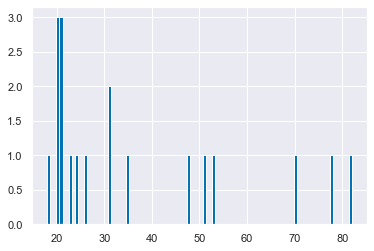

In [118]:
f2f_1974_feb[f2f_1974_feb["housing_det"]=="DK"]["age"].hist(bins=100)

# really not at all obvious what "NA" means for housing (in the process of moving?)

# DKs include a lot of v young people => prob covering 'living with family'

In [103]:
# f2f_1974_feb[f2f_1974_feb["inc"].isnull()]

In [36]:
f2f_1974_feb["inc"].value_counts(dropna=False)

upper 3rd     766
lowest 3rd    681
middle 3rd    606
NaN           409
Name: inc, dtype: int64

In [102]:
# f2f_1974_feb["inc"]

In [401]:
f2f_1974_feb["inc"]

0       middle 3rd
1       lowest 3rd
2        upper 3rd
3       lowest 3rd
4       lowest 3rd
           ...    
2457    middle 3rd
2458     upper 3rd
2459     upper 3rd
2460    lowest 3rd
2461    middle 3rd
Name: inc, Length: 2462, dtype: object

In [101]:
# alg = get_xgboost_alg(classification_problem=False)
# alg

In [48]:
inc = f2f_1974_feb["inc"].astype('category').cat.codes.replace(-1,np.nan)

In [97]:
ge = "1974_feb"
harm_vars = ["wt","age","housing_det","harmonised_voted","inc_det"]
target_var = "inc_det"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = ["Lower Income","Higher Income"]
var_stub = "inc_det"
min_features = 10
drop_vars = ["feb212"]

# alg = get_xgboost_alg(classification_problem=False)

# (explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
#                                                                                      target_var_drop_list,target_var_title_pair,
#        var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True,alg=alg)

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
# use fitted algorithm to predict values
# inc_pred = alg.predict(df_pred[train_columns])
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [51]:
df_pred.corrwith(inc).sort_values().dropna()

family income(C)                                     -0.396623
family income(B)                                     -0.385013
family income(D)                                     -0.373170
income before or after tax(no tax paid)              -0.363854
marital status of respondent(widowed or separated)   -0.359010
                                                        ...   
feb188|mortgage                                       0.390158
housing_det|MORT                                      0.390158
resp coded job status(present job)                    0.426795
resp job status(in paid job)                          0.428097
family income(H)                                      0.467375
Length: 1299, dtype: float64

In [100]:
# feb212
# variable used to get income in the first pass

# BES_label_list["1974_feb"]["feb212"]

In [99]:
# inc = BES_df_list["1974_feb"]["feb212"].replace("7",np.nan).replace("8",np.nan).astype('category').cat.codes.replace(-1,np.nan)
# inc.value_counts()

# .astype('category')
#.cat.codes

In [71]:
df_pred.corrwith(inc).sort_values().dropna()

family income(A)                                     -0.454588
family income(B)                                     -0.417021
income before or after tax(no tax paid)              -0.402011
marital status of respondent(widowed or separated)   -0.398084
resp coded job status(permanent retired)             -0.340968
                                                        ...   
family income(J)                                      0.381127
feb188|mortgage                                       0.398337
housing_det|MORT                                      0.398337
resp coded job status(present job)                    0.454036
resp job status(in paid job)                          0.455155
Length: 1299, dtype: float64

In [79]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","inc_det"] = inc

MSE: 3.69, MAE: 1.41, EV: 0.61, R2: 0.60


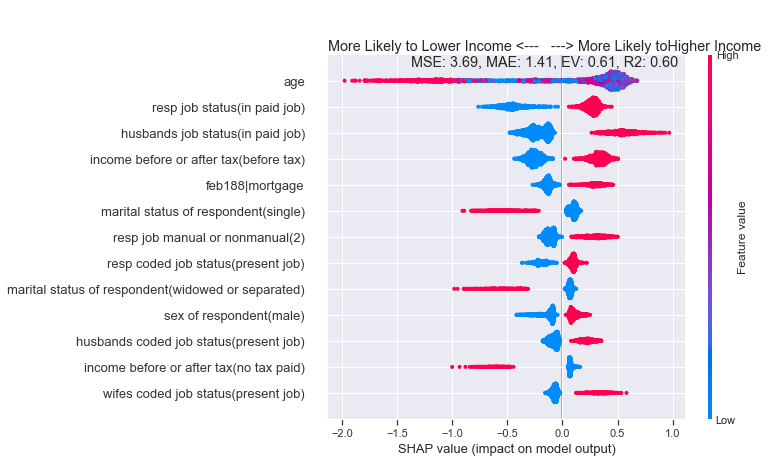

<Figure size 1152x720 with 0 Axes>

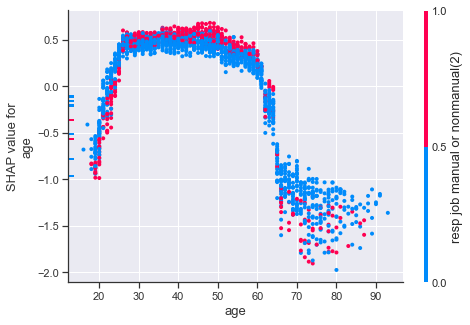

<Figure size 1152x720 with 0 Axes>

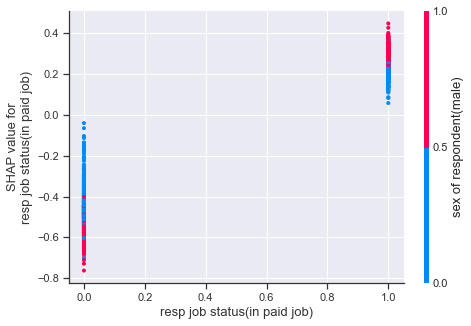

<Figure size 1152x720 with 0 Axes>

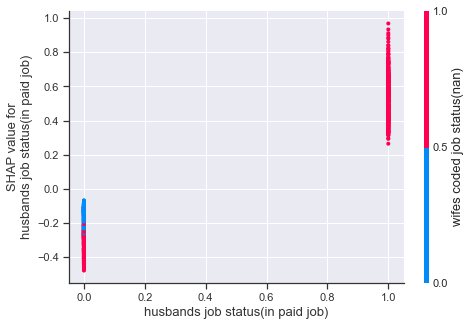

<Figure size 1152x720 with 0 Axes>

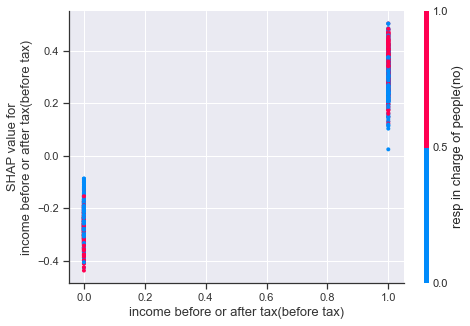

<Figure size 1152x720 with 0 Axes>

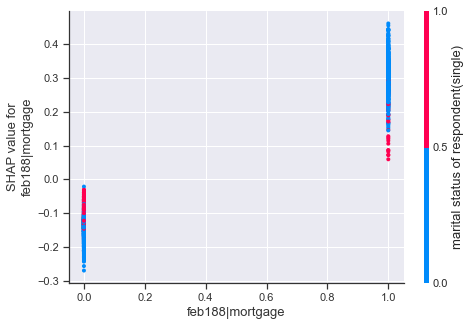

<Figure size 1152x720 with 0 Axes>

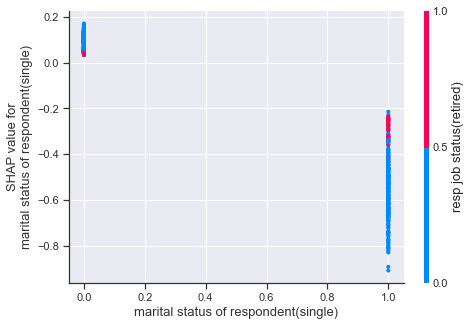

<Figure size 1152x720 with 0 Axes>

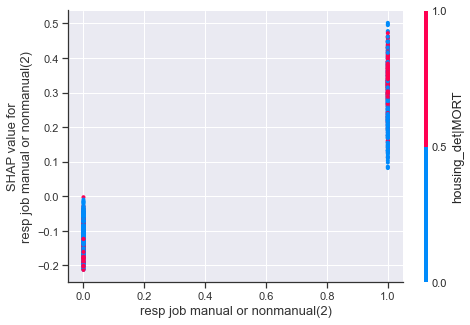

<Figure size 1152x720 with 0 Axes>

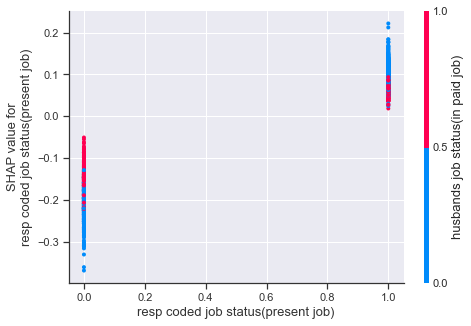

<Figure size 1152x720 with 0 Axes>

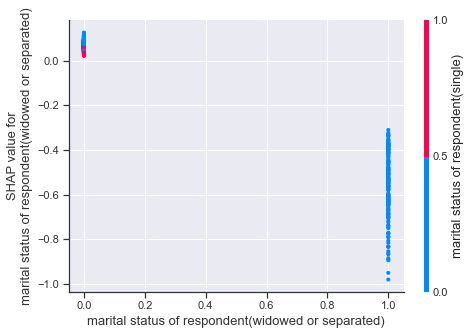

<Figure size 1152x720 with 0 Axes>

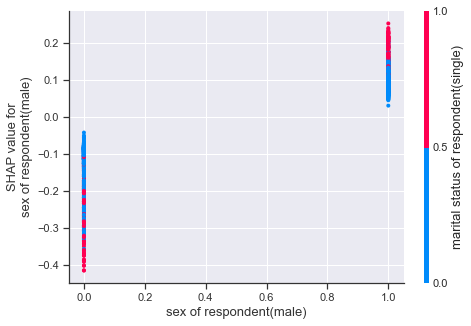

<Figure size 1152x720 with 0 Axes>

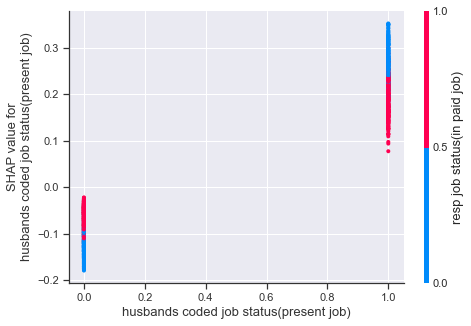

<Figure size 1152x720 with 0 Axes>

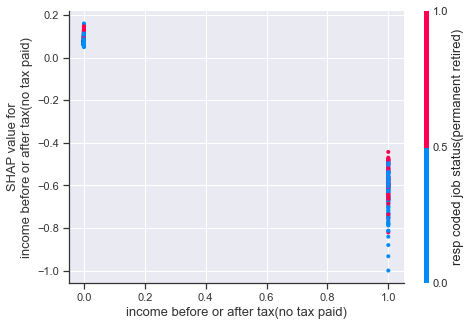

<Figure size 1152x720 with 0 Axes>

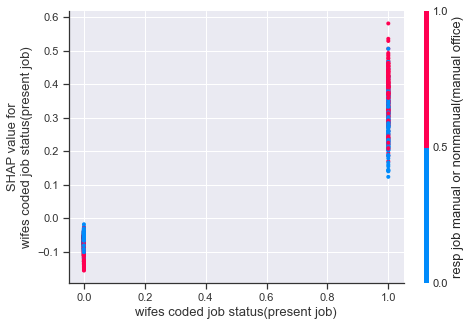

In [81]:
ge = "1974_feb"
harm_vars = ["wt","age","housing_det","harmonised_voted","inc_det"]
target_var = "inc_det"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = ["Lower Income","Higher Income"]
var_stub = "inc_det"
min_features = 10
drop_vars = ["feb212"]

alg = get_xgboost_alg(classification_problem=False)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True,alg=alg)

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
# use fitted algorithm to predict values
inc_pred = alg.predict(df_pred[train_columns])
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [96]:
inc.loc[inc.isnull()] = inc_pred.round()[inc.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","inc_det"] = inc

In [400]:
inc

0        4.0
1        1.0
2        7.0
3        1.0
4        1.0
        ... 
2457     6.0
2458     8.0
2459    10.0
2460     0.0
2461     5.0
Length: 2462, dtype: float64

ACC: 0.76,  F1: 0.76


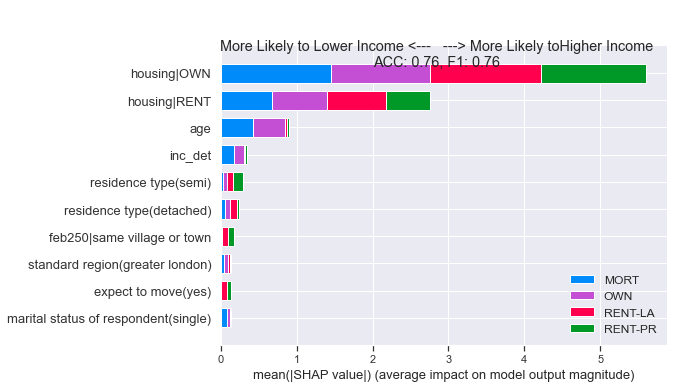

In [274]:
ge = "1974_feb"
harm_vars = ["wt","age","housing_det","harmonised_voted","inc_det","housing"]
target_var = "housing_det"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = ["Lower Income","Higher Income"]
var_stub = "housing_det"
min_features = 10
drop_vars = ['feb187','feb188','feb189']

alg = get_xgboost_alg(classification_problem=True)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=True,alg=alg,multi_class_target=True)

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
# use fitted algorithm to predict values
housing_pred = alg.predict(df_pred[train_columns])
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [ ]:
# df_pred.corrwith(f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing_det"]=="MORT").sort_values().dropna()

# #  'feb187': 'home owned or rented',
# #  'feb188': 'mode of home ownership',
# #  'feb189': 'mode of home rental',

# residence type

In [273]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing_det"].value_counts()

RENT-LA    743
MORT       717
OWN        553
RENT-PR    373
Name: housing_det, dtype: int64

In [275]:
housing_pred[mask]


array(['OWN', 'MORT', 'OWN', 'OWN', 'OWN', 'MORT', 'OWN', 'MORT', 'OWN',
       'OWN', 'OWN', 'OWN', 'OWN', 'MORT', 'OWN', 'OWN', 'MORT', 'MORT',
       'MORT', 'MORT'], dtype=object)

In [121]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing"].value_counts()

OWN     1290
RENT    1110
OTH       53
NA         6
DK         3
Name: housing, dtype: int64

In [136]:
housing = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing_det"].copy()

In [137]:
mask = housing.isnull() & f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing"].apply(lambda x: x in ["NA","OWN","RENT"])
housing.loc[mask] = pd.Series(housing_pred,index=housing.index).loc[mask]
housing = housing.replace("DK",np.nan)
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing_det"] = housing

In [277]:
housing.loc[mask] = housing_pred[mask]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing_det"] = housing

In [265]:
housing.value_counts(dropna=False)

RENT-LA    743
MORT       717
OWN        553
RENT-PR    373
NaN         76
Name: housing_det, dtype: int64

In [268]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing"][housing.isnull()].value_counts(dropna=False)

OTH    53
OWN    20
DK      3
Name: housing, dtype: int64

In [269]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing"][housing.isnull()]

mask = housing.isnull() & (f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing"]=="OWN")
# mask.sum()

20

In [271]:
BES_df_list["1974_feb"][mask][["feb187",'feb188','feb189']]

feb187 feb188 feb189
163   owned     dk    NaN
182   owned     dk    NaN
403   owned     dk    NaN
512   owned     dk    NaN
514   owned     dk    NaN
1015  owned     dk    NaN
1100  owned     dk    NaN
1253  owned     dk    NaN
1408  owned     dk    NaN
1480  owned     dk    NaN
1482  owned     dk    NaN
1505  owned     dk    NaN
1604  owned     dk    NaN
1905  owned     dk    NaN
1909  owned     dk    NaN
1948  owned     dk    NaN
2174  owned     dk    NaN
2180  owned     dk    NaN
2181  owned     dk    NaN
2204  owned     dk    NaN

In [278]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing_det"].value_counts(dropna=False)

RENT-LA    743
MORT       725
OWN        565
RENT-PR    373
NaN         56
Name: housing_det, dtype: int64

MSE: 78.79, MAE: 6.78, EV: 0.74, R2: 0.74


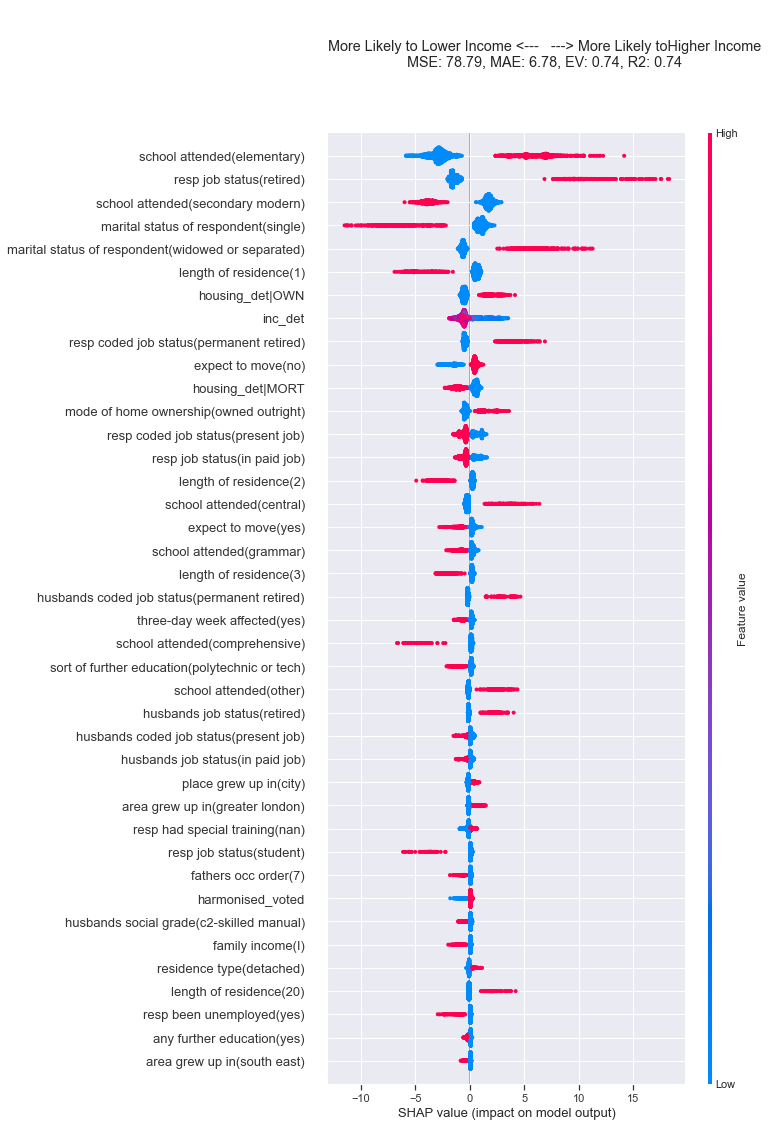

<Figure size 1152x720 with 0 Axes>

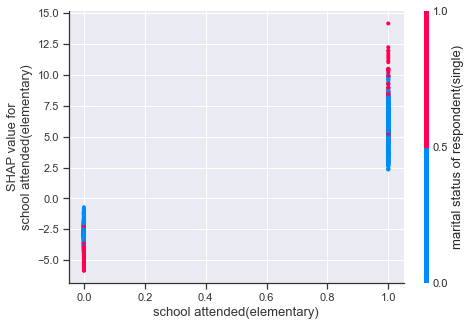

<Figure size 1152x720 with 0 Axes>

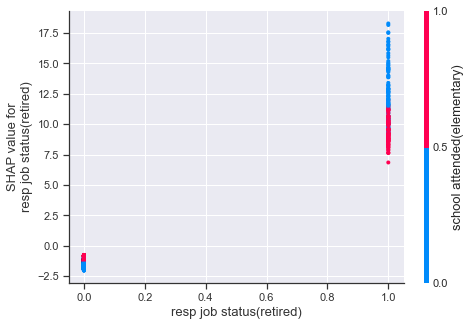

<Figure size 1152x720 with 0 Axes>

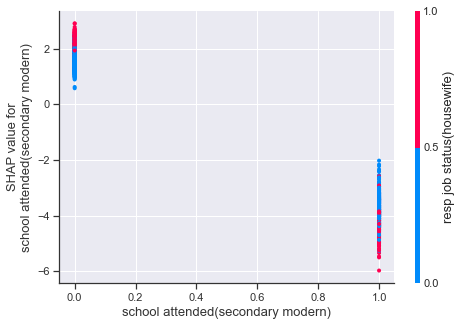

<Figure size 1152x720 with 0 Axes>

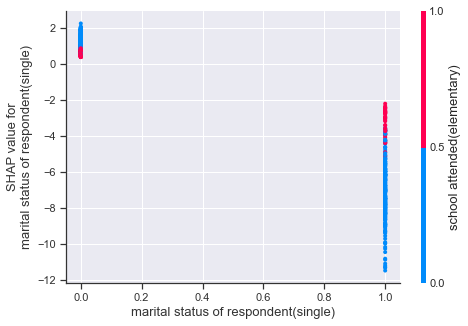

<Figure size 1152x720 with 0 Axes>

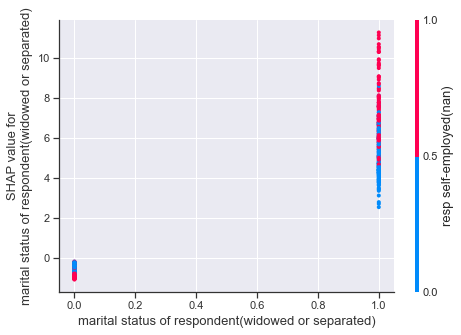

<Figure size 1152x720 with 0 Axes>

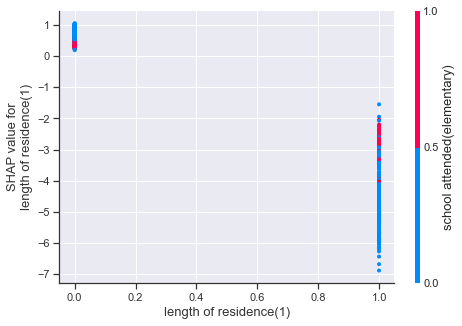

<Figure size 1152x720 with 0 Axes>

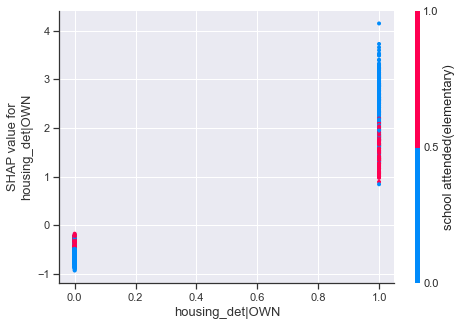

<Figure size 1152x720 with 0 Axes>

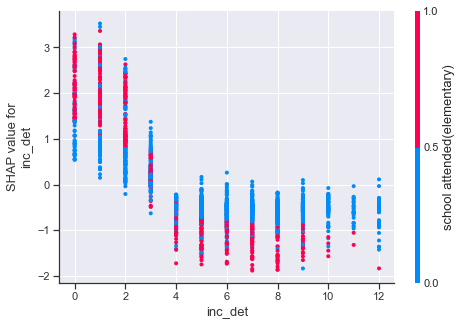

<Figure size 1152x720 with 0 Axes>

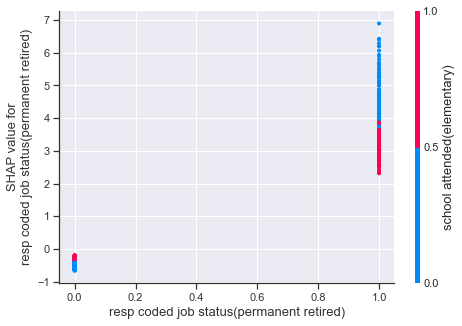

<Figure size 1152x720 with 0 Axes>

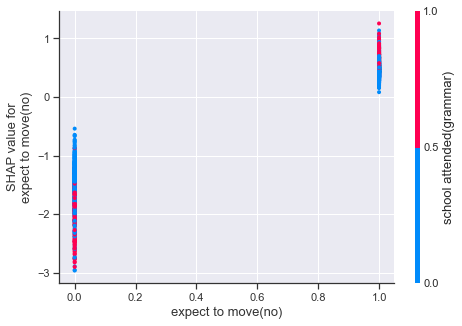

<Figure size 1152x720 with 0 Axes>

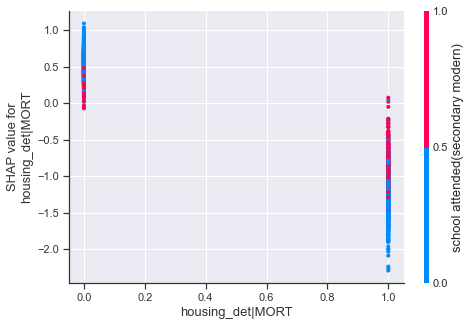

<Figure size 1152x720 with 0 Axes>

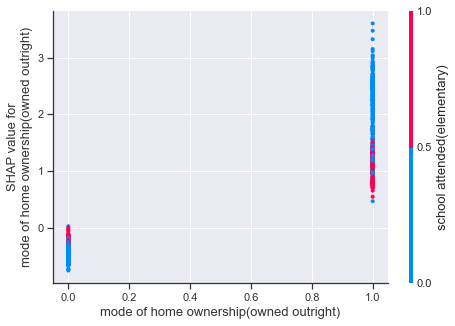

<Figure size 1152x720 with 0 Axes>

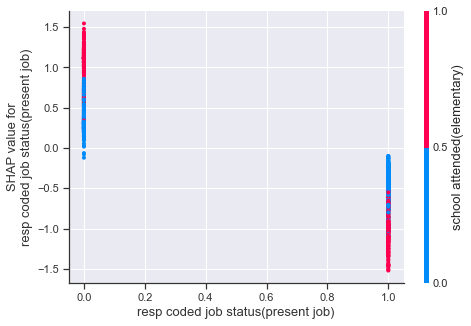

<Figure size 1152x720 with 0 Axes>

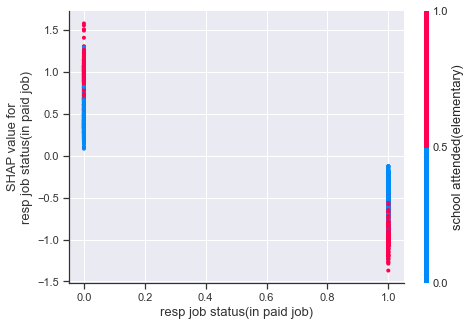

<Figure size 1152x720 with 0 Axes>

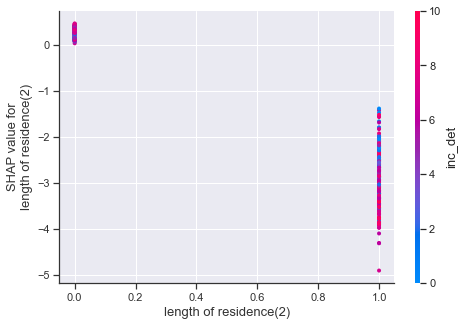

<Figure size 1152x720 with 0 Axes>

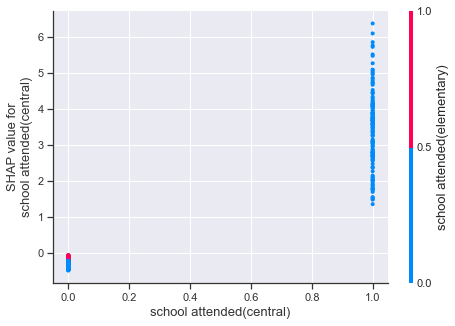

<Figure size 1152x720 with 0 Axes>

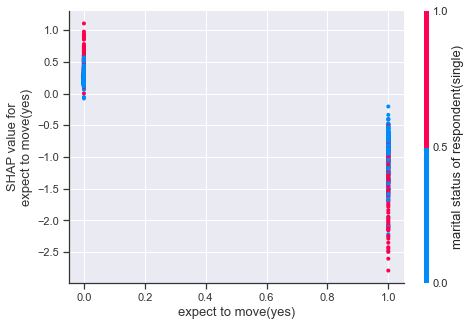

<Figure size 1152x720 with 0 Axes>

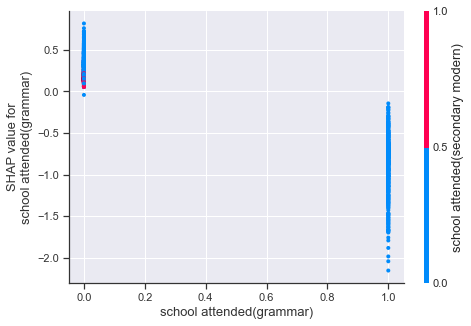

<Figure size 1152x720 with 0 Axes>

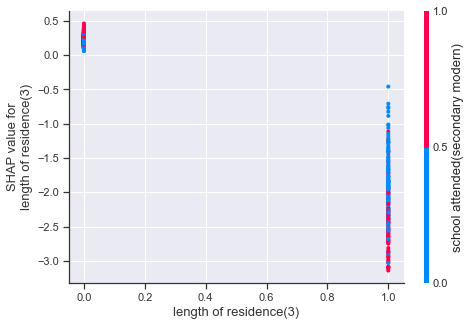

<Figure size 1152x720 with 0 Axes>

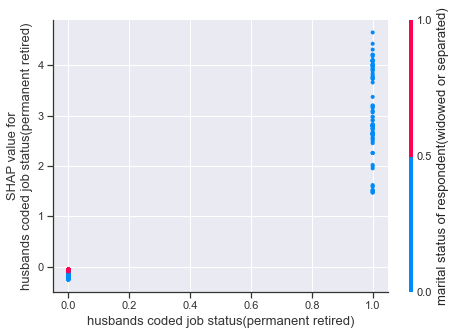

<Figure size 1152x720 with 0 Axes>

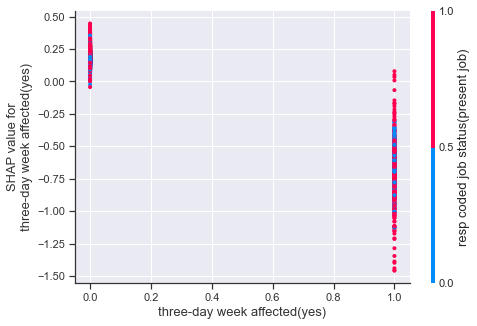

<Figure size 1152x720 with 0 Axes>

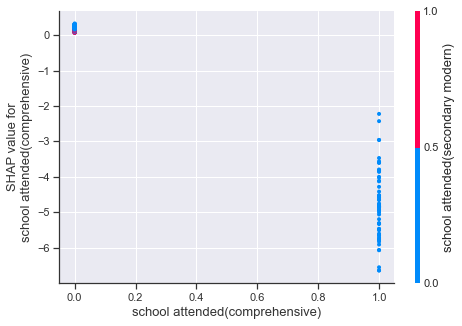

<Figure size 1152x720 with 0 Axes>

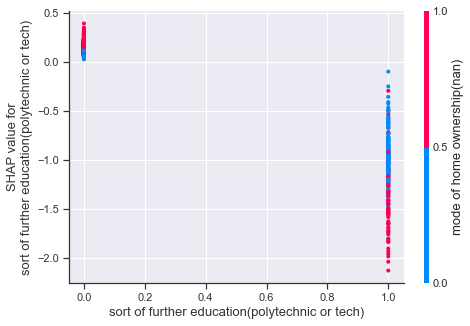

<Figure size 1152x720 with 0 Axes>

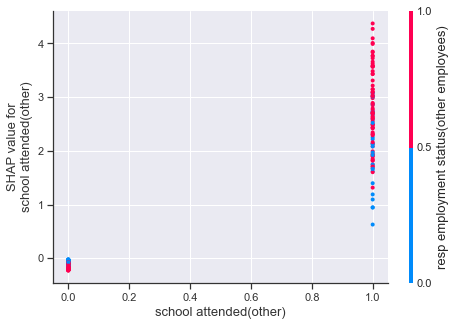

<Figure size 1152x720 with 0 Axes>

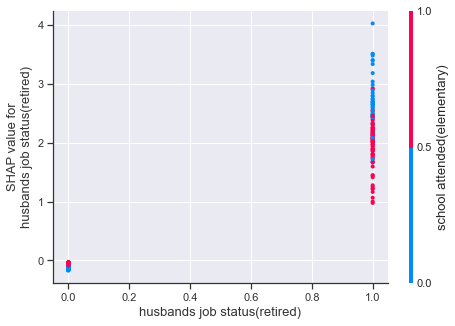

<Figure size 1152x720 with 0 Axes>

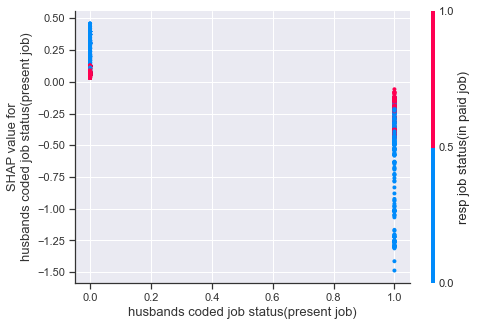

<Figure size 1152x720 with 0 Axes>

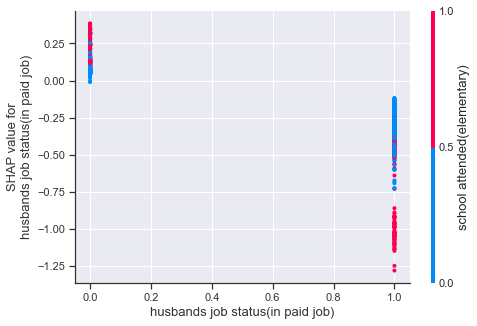

<Figure size 1152x720 with 0 Axes>

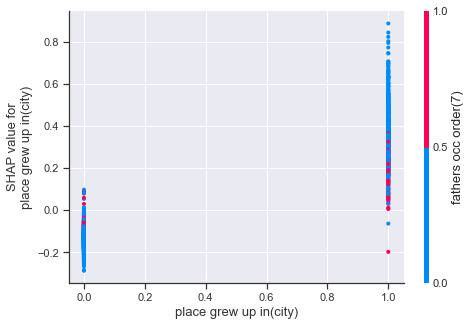

<Figure size 1152x720 with 0 Axes>

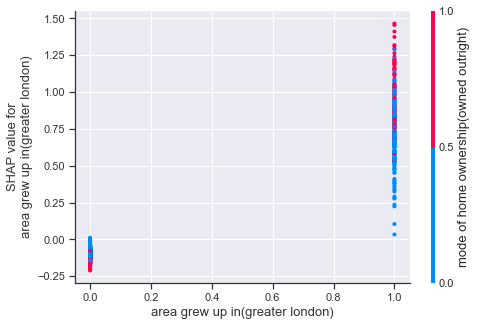

<Figure size 1152x720 with 0 Axes>

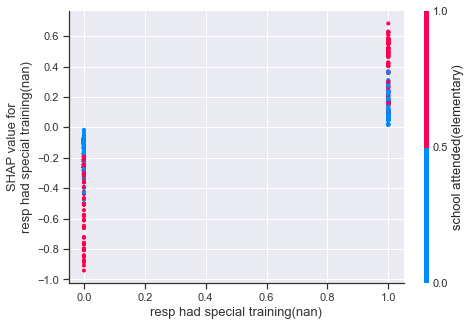

<Figure size 1152x720 with 0 Axes>

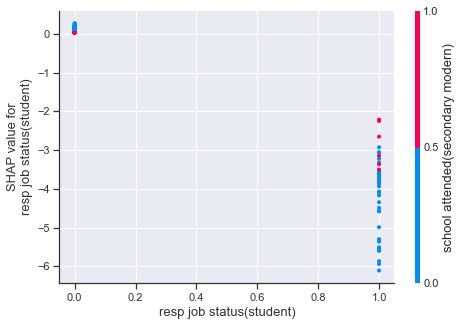

<Figure size 1152x720 with 0 Axes>

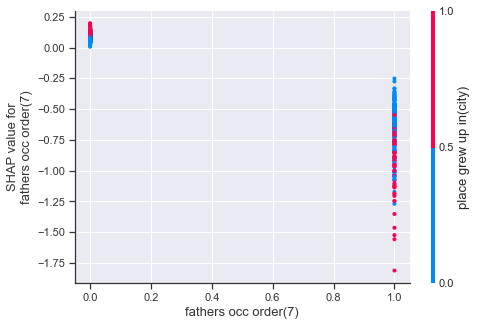

<Figure size 1152x720 with 0 Axes>

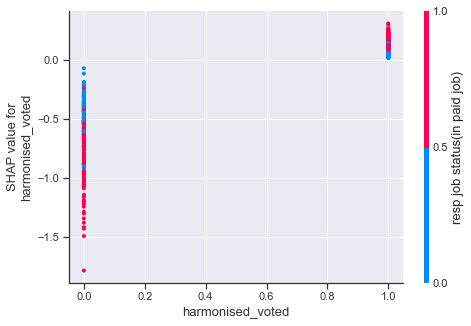

<Figure size 1152x720 with 0 Axes>

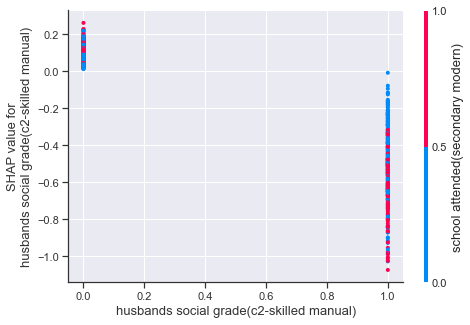

<Figure size 1152x720 with 0 Axes>

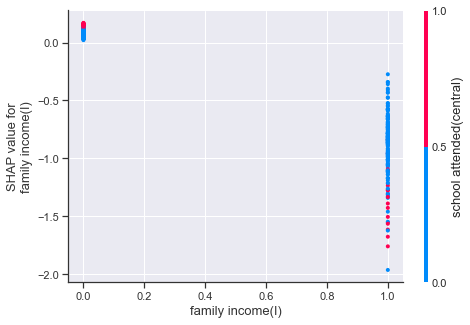

<Figure size 1152x720 with 0 Axes>

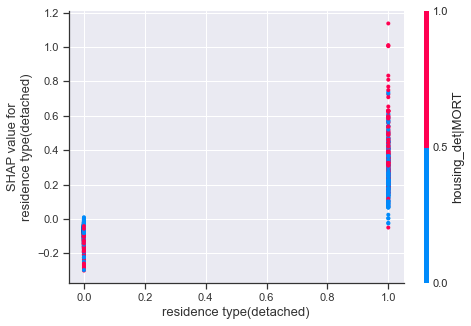

<Figure size 1152x720 with 0 Axes>

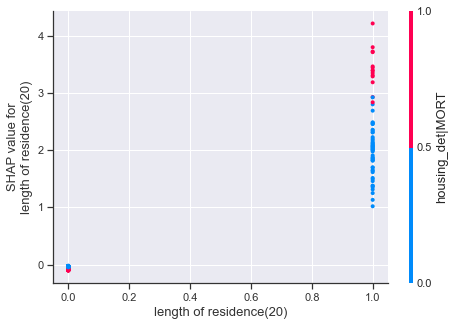

<Figure size 1152x720 with 0 Axes>

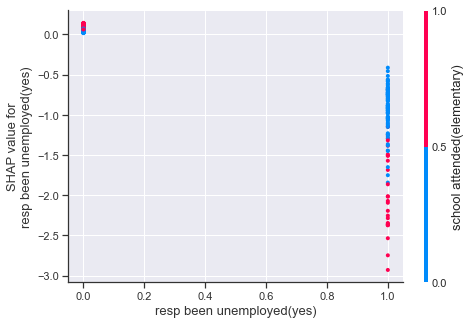

<Figure size 1152x720 with 0 Axes>

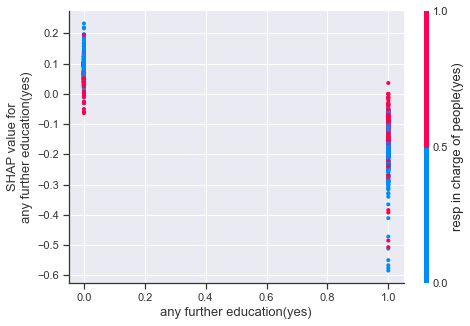

<Figure size 1152x720 with 0 Axes>

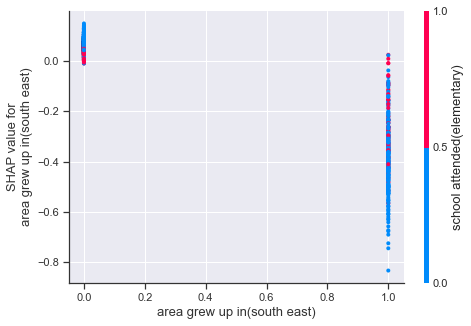

In [144]:
ge = "1974_feb"
harm_vars = ["wt","age","housing_det","harmonised_voted","inc_det"]
target_var = "age"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = ["Lower Income","Higher Income"]
var_stub = "age"
min_features = 10
drop_vars = ["feb191"]

alg = get_xgboost_alg(classification_problem=False)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True,alg=alg)

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
# use fitted algorithm to predict values
age_pred = alg.predict(df_pred[train_columns])
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [145]:
# df_pred.corrwith(f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","age"]).sort_values().dropna()

In [154]:
age_pred = pd.Series(age_pred,index = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","age"].index).round()

In [156]:
age = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","age"]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","age"].loc[age.isnull()] = age_pred[age.isnull()]

In [161]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","age"].isnull().sum()

22

In [160]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","age"].loc[age.isnull()] = age_pred[age.isnull()]

In [169]:
age[age.isnull()] = age_pred[age.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","age"] = age

In [171]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","age"].isnull().sum()

0

In [ ]:
### 

In [175]:
f2f_1974_feb["vote"].value_counts(dropna=False)

LAB    841
CON    787
LIB    395
DNV    298
DK      94
SNP     38
PC       6
OTH      3
Name: vote, dtype: int64

In [176]:
f2f_1974_feb["vote_simple"].value_counts(dropna=False)

LAB    841
CON    787
LD     395
DNV    298
DK      94
SNP     38
PC       6
NaN      3
Name: vote_simple, dtype: int64

In [177]:
f2f_1974_feb[ f2f_1974_feb["vote_simple"]=="DK" ]

dataset            uid housing_det housing         inc vote  year   wt  \
3     1974_feb     1974_feb|3     RENT-LA    RENT  lowest 3rd   DK  1974  1.0   
58    1974_feb    1974_feb|58     RENT-LA    RENT         NaN   DK  1974  1.0   
112   1974_feb   1974_feb|112     RENT-LA    RENT         NaN   DK  1974  1.0   
128   1974_feb   1974_feb|128     RENT-LA    RENT  lowest 3rd   DK  1974  1.0   
146   1974_feb   1974_feb|146         OWN     OWN         NaN   DK  1974  1.0   
...        ...            ...         ...     ...         ...  ...   ...  ...   
2400  1974_feb  1974_feb|2400        MORT     OWN   upper 3rd   DK  1974  1.0   
2417  1974_feb  1974_feb|2417     RENT-LA    RENT  middle 3rd   DK  1974  1.0   
2425  1974_feb  1974_feb|2425     RENT-PR    RENT   upper 3rd   DK  1974  1.0   
2427  1974_feb  1974_feb|2427     RENT-LA    RENT  lowest 3rd   DK  1974  1.0   
2451  1974_feb  1974_feb|2451     RENT-LA    RENT  middle 3rd   DK  1974  1.0   

       age vote_simple     bloc  birth_year  harmonised_voted  inc_det  \
3     87.0          DK  Neither      1887.0               1.0      NaN   
58    55.0          DK  Neither      1919.0               1.0      NaN   
112   72.0          DK  Neither      1902.0               1.0      NaN   
128   28.0          DK  Neither      1946.0               1.0      NaN   
146   60.0          DK  Neither      1914.0               1.0      NaN   
...    ...         ...      ...         ...               ...      ...   
2400  39.0          DK  Neither      1935.0               1.0      NaN   
2417  20.0          DK  Neither      1954.0               1.0      NaN   
2425  26.0          DK  Neither      1948.0               1.0      NaN   
2427  80.0          DK  Neither      1894.0               1.0      NaN   
2451  56.0          DK  Neither      1918.0               1.0      NaN   

     vote_complete vote_complete_simple bloc_complete turnout_complete  
3              NaN                  NaN           NaN              NaN  
58             NaN                  NaN           NaN              NaN  
112            NaN                  NaN           NaN              NaN  
128            NaN                  NaN           NaN              NaN  
146            NaN                  NaN           NaN              NaN  
...            ...                  ...           ...              ...  
2400           NaN                  NaN           NaN              NaN  
2417           NaN                  NaN           NaN              NaN  
2425           NaN                  NaN           NaN              NaN  
2427           NaN                  NaN           NaN              NaN  
2451           NaN                  NaN           NaN              NaN  

[94 rows x 18 columns]

In [ ]:
## fill in the blanks on the DKs

In [182]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","vote_complete"]=f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","vote"].replace("DK",np.nan)

ACC: 0.96,  F1: 0.96


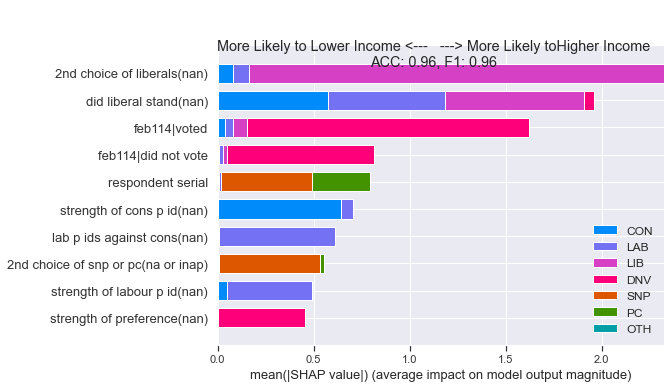

In [238]:
ge = "1974_feb"
harm_vars = ["wt","age","housing_det","vote_complete","inc_det","housing"]
target_var = "vote_complete"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = ["Lower Income","Higher Income"]
var_stub = "vote_complete"
min_features = 10
drop_vars = ['feb115','feb122']
## vital to drop feb122!!!

drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<.5].index)
drop_vars.remove("vote_complete")
drop_vars.remove("wt")

alg = get_xgboost_alg(classification_problem=True)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,alg=alg,multi_class_target=True)

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
vote_pred = alg.predict(df_pred[train_columns])
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

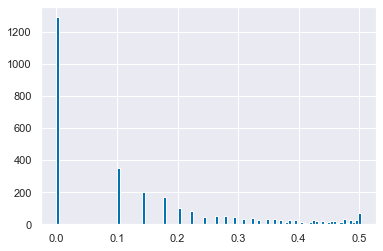

In [210]:
stds = df_pred[vote_complete.isnull()].std()
stds[stds<1].hist(bins=100)


In [195]:
# %debug

In [244]:
{k:v for k,v in BES_label_list["1974_feb"].items() if 'labour party' in v.lower()}

{'feb032': 'blame prices on labour party',
 'feb042': 'miners strike blame labour party'}

In [241]:
pd.Series(vote_pred).value_counts()

LAB    889
CON    822
LIB    405
DNV    301
SNP     40
PC       5
dtype: int64

In [242]:
pd.Series(vote_pred)[vote_complete.isnull()].value_counts()

LAB    45
CON    31
LIB    11
DNV     3
SNP     3
PC      1
dtype: int64

In [264]:
temp = BES_df_list["1974_feb"][['feb114','feb115','feb118','feb120','feb125','feb126','feb111','feb140']][vote_complete.isnull()].copy()
temp["prediction"] = vote_pred[vote_complete.isnull()]
# temp.head(50)

In [ ]:
# acc/f1 = .5

In [246]:
vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","vote_complete"]
pd.Series(vote_pred[vote_complete.isnull()]).value_counts()
vote_complete.loc[vote_complete.isnull()] = vote_pred[vote_complete.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","vote_complete"] = vote_complete

In [248]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","vote_complete"].value_counts(dropna=False)

LAB    886
CON    818
LIB    406
DNV    301
SNP     41
PC       7
OTH      3
Name: vote_complete, dtype: int64

In [254]:
vote_simple = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","vote_complete"].replace(simple_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","vote_complete_simple"] = vote_simple
vote_simple.value_counts(dropna=False)

LAB    886
CON    818
LD     406
DNV    301
SNP     41
PC       7
DK       3
Name: vote_complete, dtype: int64

In [257]:
bloc_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","vote_complete_simple"].replace(bloc_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","bloc_complete"] = bloc_complete
bloc_complete.value_counts()

Left-Lib      1340
Right-Auth     818
Neither        301
Name: vote_complete_simple, dtype: int64

In [261]:
turnout_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","vote_complete"].replace(turnout_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","turnout_complete"] = turnout_complete
turnout_complete.value_counts(dropna=False)

VOTED    2161
DNV       301
Name: vote_complete, dtype: int64

In [280]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb"].isnull().sum()

dataset                   0
uid                       0
housing_det              56
housing                   0
inc                     409
vote                      0
year                      0
wt                        0
age                       0
vote_simple               3
bloc                      0
birth_year               22
harmonised_voted          0
inc_det                   0
vote_complete             0
vote_complete_simple      0
bloc_complete             3
turnout_complete          0
dtype: int64

In [263]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","housing_det"].value_counts(dropna=False)

RENT-LA    743
MORT       717
OWN        553
RENT-PR    373
NaN         76
Name: housing_det, dtype: int64

In [281]:
f2f_harmonised.to_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')

In [ ]:
## 

In [284]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct"].isnull().sum()

# age (10) DONE
# housing_det 18 DKs (of which 16 we know OWN/RENT) DONE
# vote (63DKs) DONE
# inc - whole bunch of missing values 

dataset                    0
uid                        0
housing_det                0
housing                    0
inc                      348
vote                       0
year                       0
wt                         0
age                       10
vote_simple                7
bloc                       0
birth_year                10
harmonised_voted           0
inc_det                 2365
vote_complete           2365
vote_complete_simple    2365
bloc_complete           2365
turnout_complete        2365
dtype: int64

In [286]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","housing_det"].value_counts()

MORT       716
RENT-LA    697
OWN        532
RENT-PR    386
DK          18
NA          16
Name: housing_det, dtype: int64

In [287]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","housing"].value_counts()

OWN     1262
RENT    1085
NA        16
DK         2
Name: housing, dtype: int64

In [ ]:
### age: 1974_oct

In [291]:
age = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","age"].copy()

MSE: 83.11, MAE: 7.11, EV: 0.73, R2: 0.73


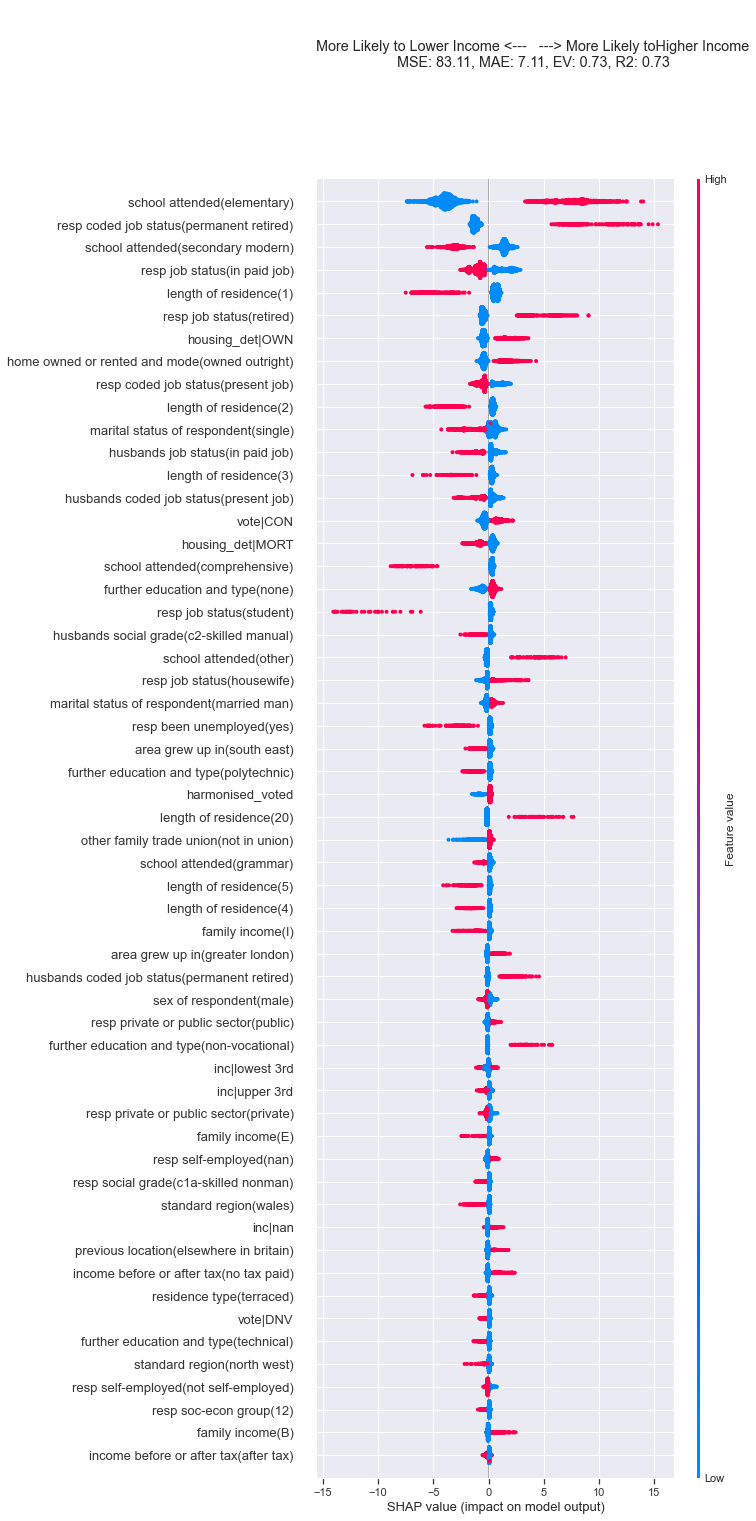

<Figure size 1152x720 with 0 Axes>

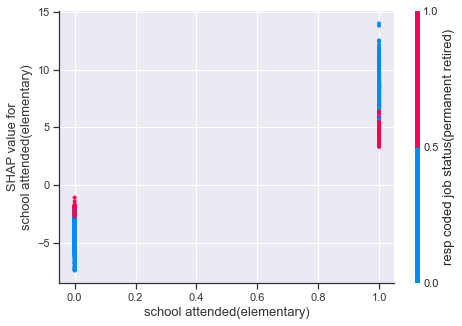

<Figure size 1152x720 with 0 Axes>

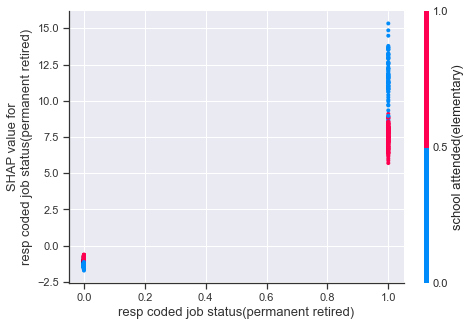

<Figure size 1152x720 with 0 Axes>

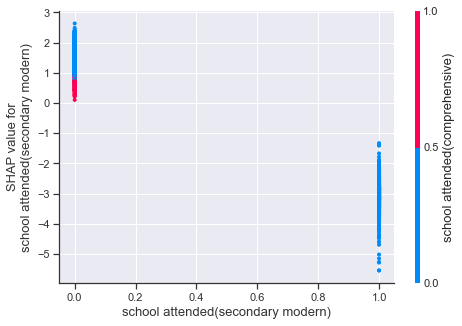

<Figure size 1152x720 with 0 Axes>

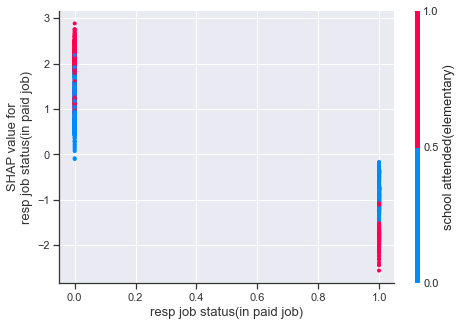

<Figure size 1152x720 with 0 Axes>

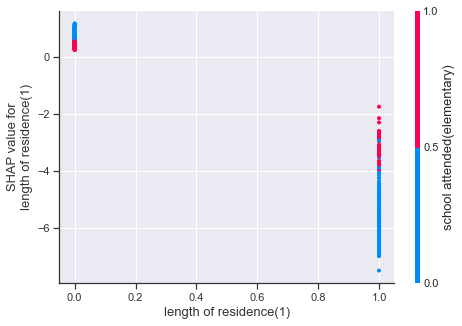

<Figure size 1152x720 with 0 Axes>

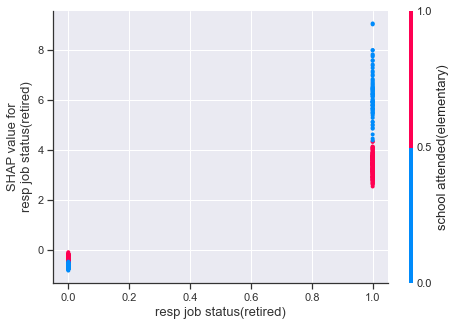

<Figure size 1152x720 with 0 Axes>

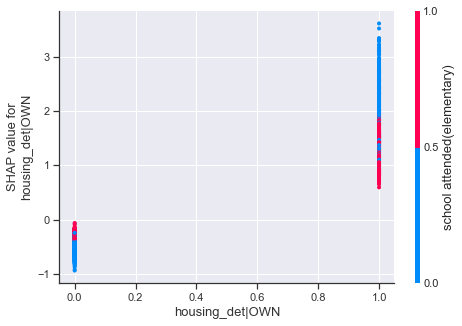

<Figure size 1152x720 with 0 Axes>

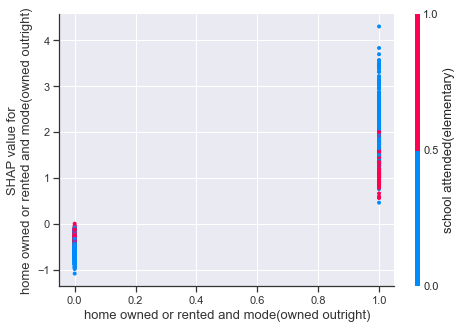

<Figure size 1152x720 with 0 Axes>

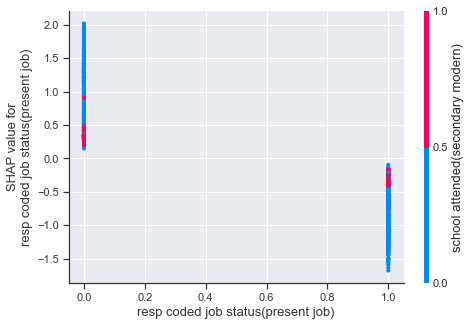

<Figure size 1152x720 with 0 Axes>

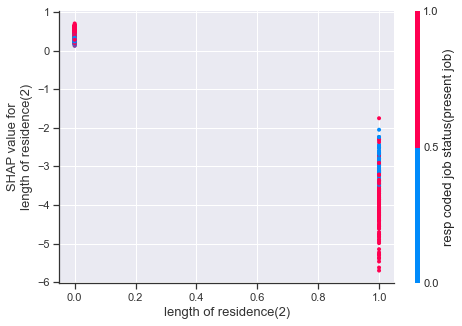

<Figure size 1152x720 with 0 Axes>

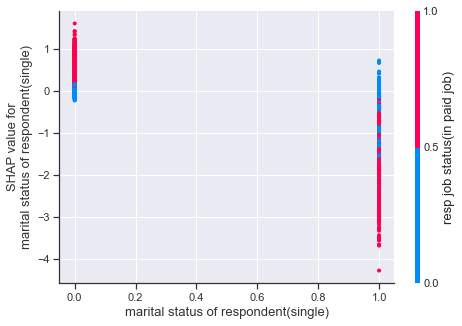

<Figure size 1152x720 with 0 Axes>

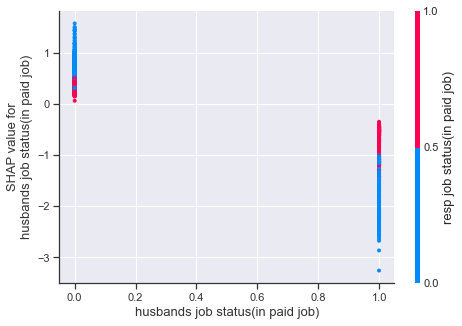

<Figure size 1152x720 with 0 Axes>

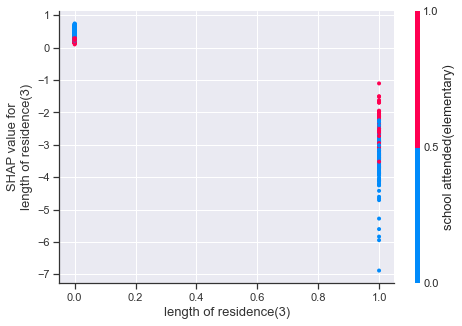

<Figure size 1152x720 with 0 Axes>

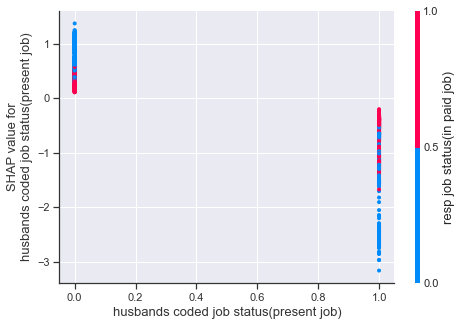

<Figure size 1152x720 with 0 Axes>

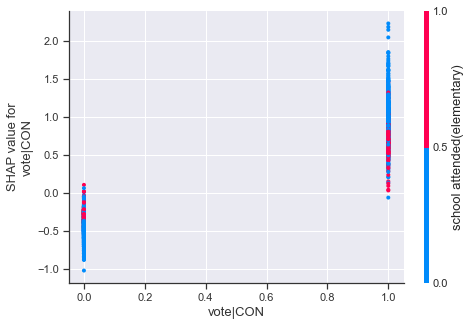

<Figure size 1152x720 with 0 Axes>

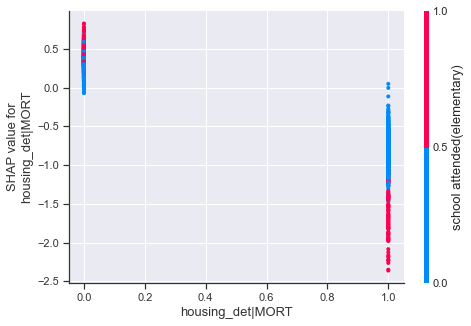

<Figure size 1152x720 with 0 Axes>

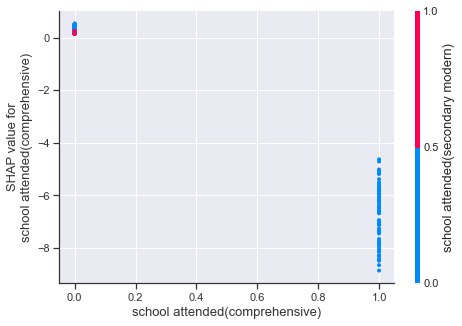

<Figure size 1152x720 with 0 Axes>

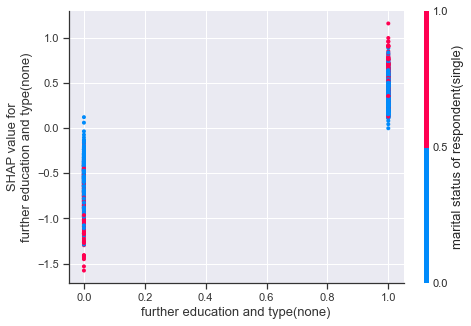

<Figure size 1152x720 with 0 Axes>

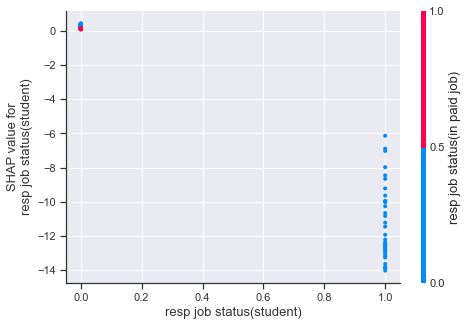

<Figure size 1152x720 with 0 Axes>

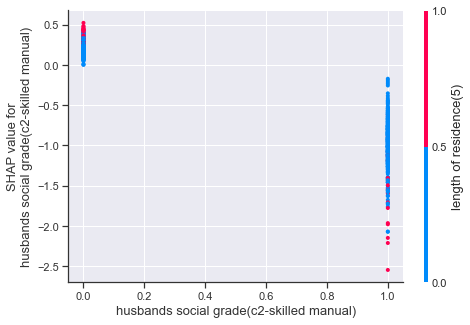

<Figure size 1152x720 with 0 Axes>

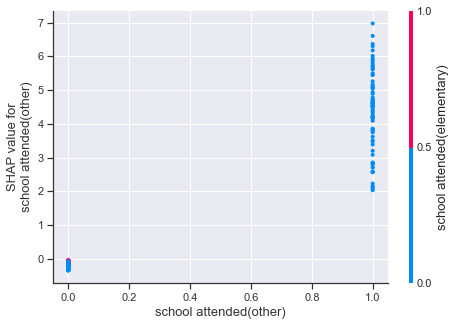

<Figure size 1152x720 with 0 Axes>

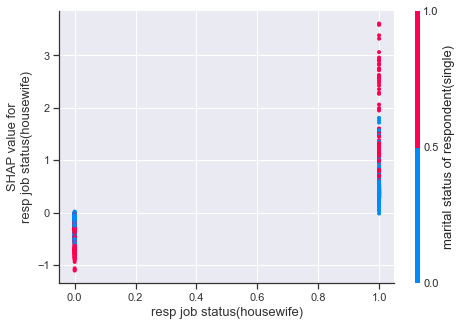

<Figure size 1152x720 with 0 Axes>

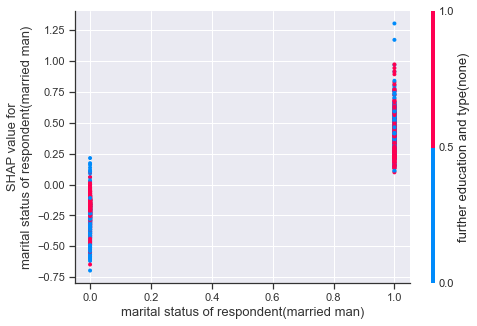

<Figure size 1152x720 with 0 Axes>

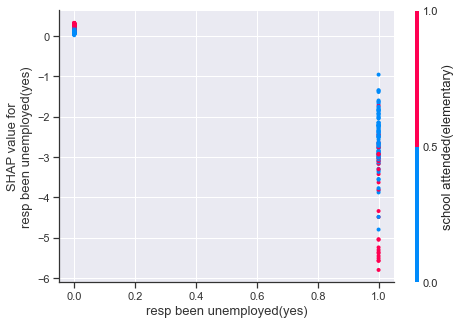

<Figure size 1152x720 with 0 Axes>

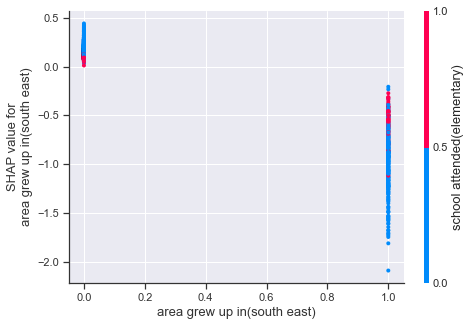

<Figure size 1152x720 with 0 Axes>

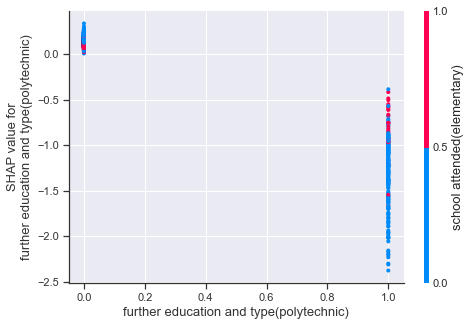

<Figure size 1152x720 with 0 Axes>

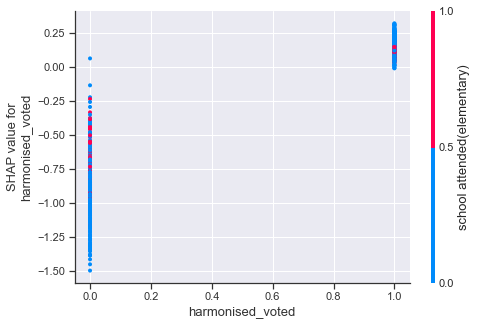

<Figure size 1152x720 with 0 Axes>

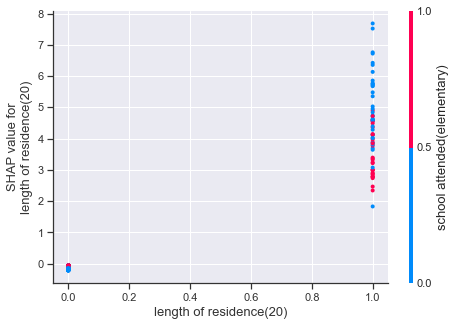

<Figure size 1152x720 with 0 Axes>

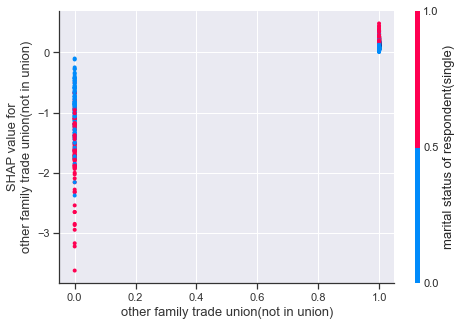

<Figure size 1152x720 with 0 Axes>

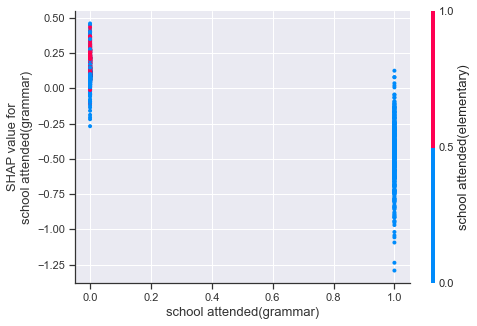

<Figure size 1152x720 with 0 Axes>

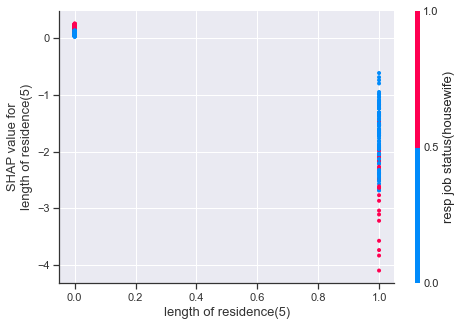

<Figure size 1152x720 with 0 Axes>

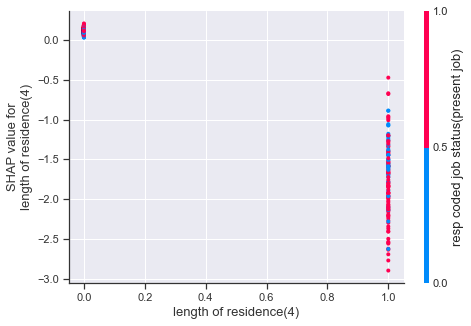

<Figure size 1152x720 with 0 Axes>

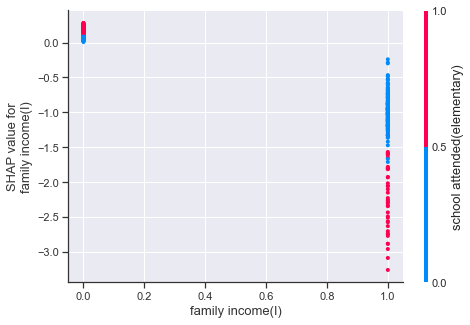

<Figure size 1152x720 with 0 Axes>

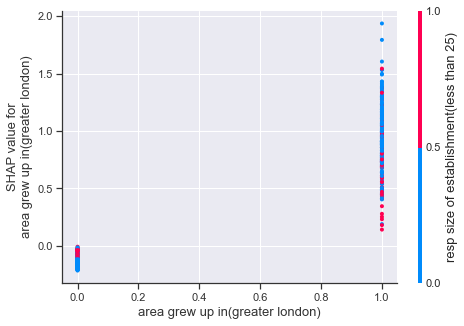

<Figure size 1152x720 with 0 Axes>

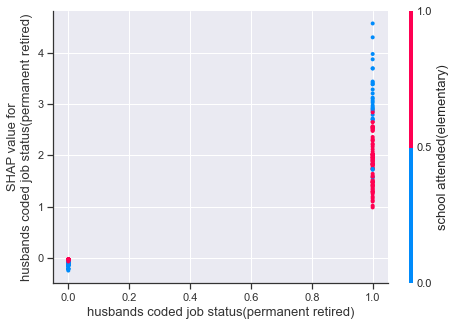

<Figure size 1152x720 with 0 Axes>

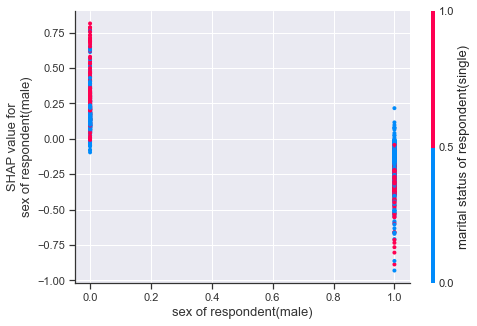

<Figure size 1152x720 with 0 Axes>

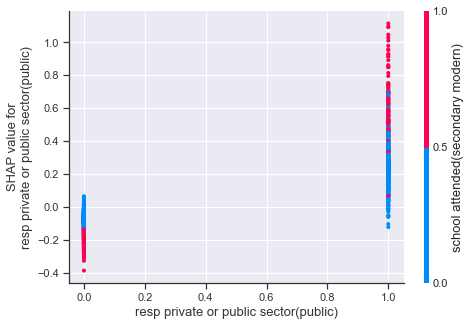

<Figure size 1152x720 with 0 Axes>

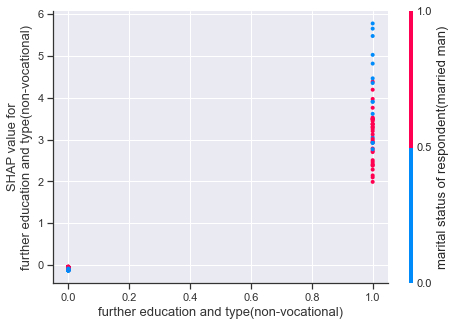

<Figure size 1152x720 with 0 Axes>

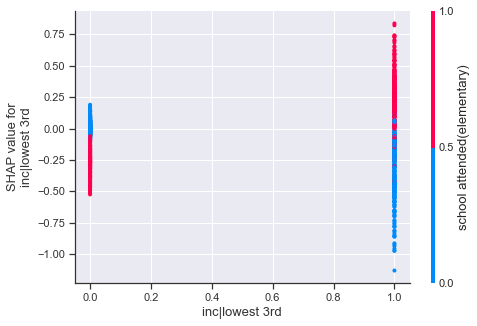

<Figure size 1152x720 with 0 Axes>

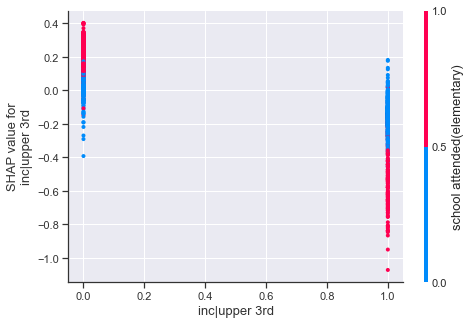

<Figure size 1152x720 with 0 Axes>

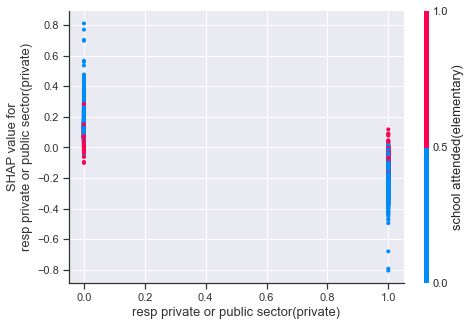

<Figure size 1152x720 with 0 Axes>

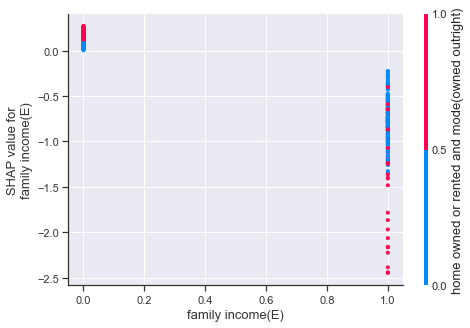

<Figure size 1152x720 with 0 Axes>

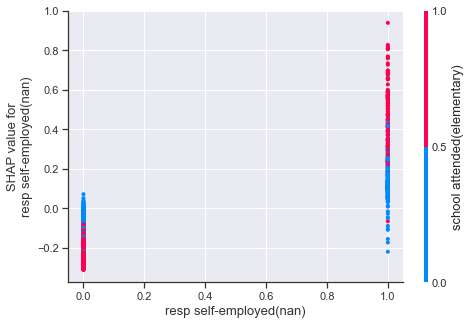

<Figure size 1152x720 with 0 Axes>

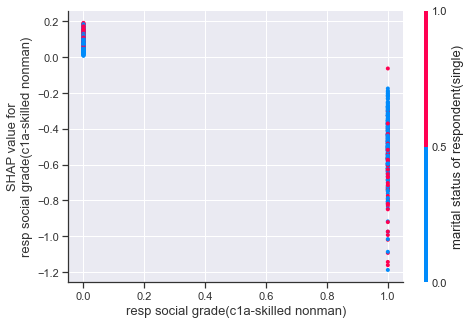

<Figure size 1152x720 with 0 Axes>

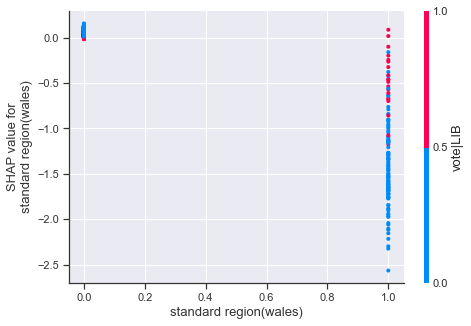

<Figure size 1152x720 with 0 Axes>

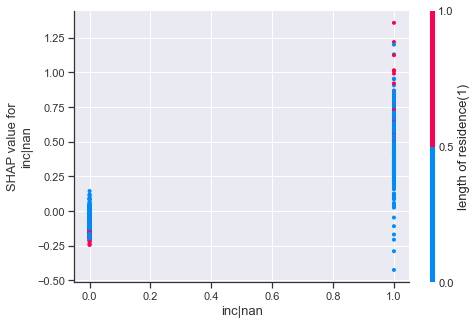

<Figure size 1152x720 with 0 Axes>

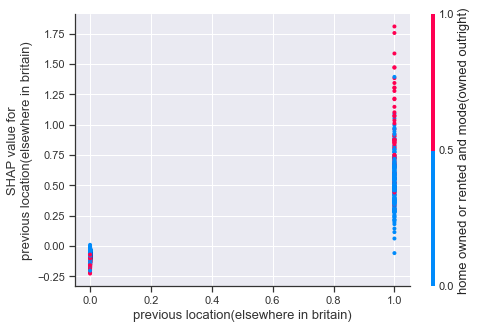

<Figure size 1152x720 with 0 Axes>

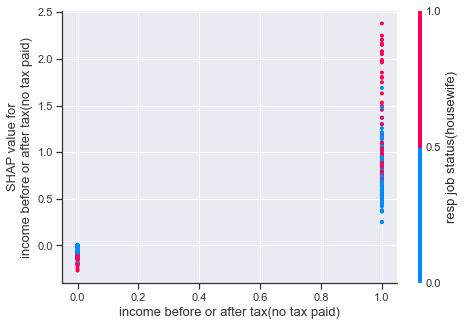

<Figure size 1152x720 with 0 Axes>

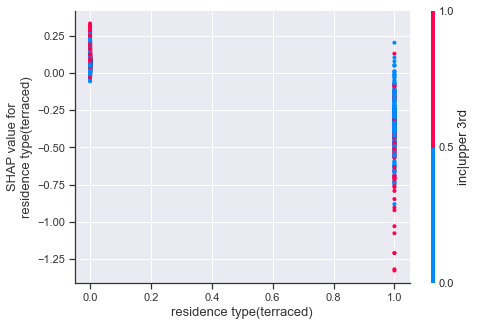

<Figure size 1152x720 with 0 Axes>

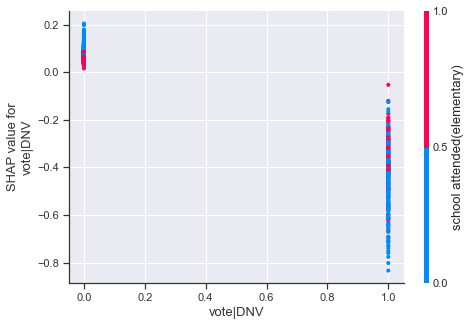

<Figure size 1152x720 with 0 Axes>

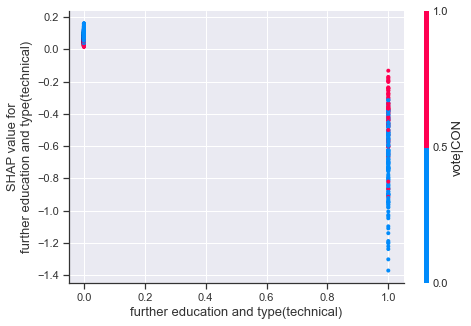

<Figure size 1152x720 with 0 Axes>

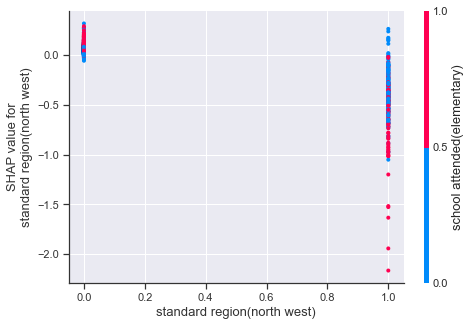

<Figure size 1152x720 with 0 Axes>

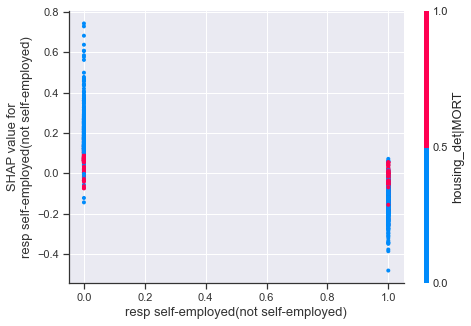

<Figure size 1152x720 with 0 Axes>

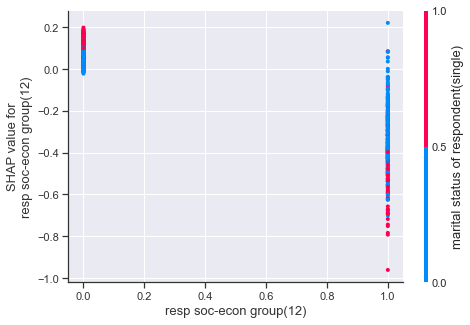

<Figure size 1152x720 with 0 Axes>

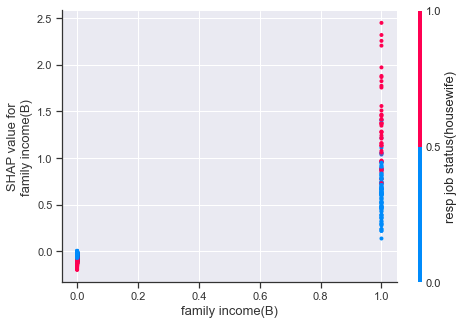

<Figure size 1152x720 with 0 Axes>

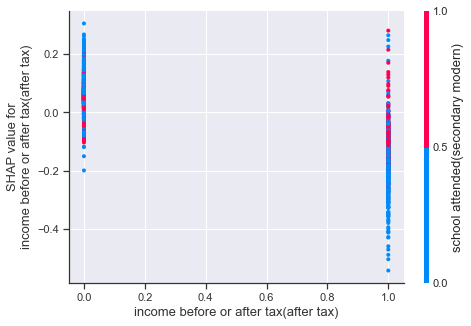

In [304]:
ge = "1974_oct"
harm_vars = ["wt","age","housing_det","harmonised_voted","inc","vote"]
target_var = "age"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = ["Lower Income","Higher Income"]
var_stub = "age"
min_features = 10
drop_vars = ["oct191"]
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds==0].index)
drop_vars.remove("wt")
drop_vars.remove("age")

alg = get_xgboost_alg(classification_problem=False)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True,alg=alg)

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
# use fitted algorithm to predict values
age_pred = alg.predict(df_pred[train_columns])
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [301]:
stds = df_pred[age.isnull()].std()

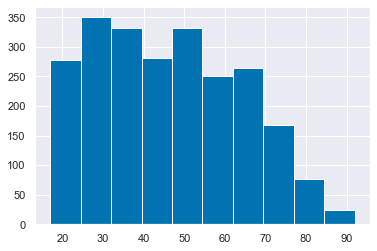

In [305]:
age.hist()

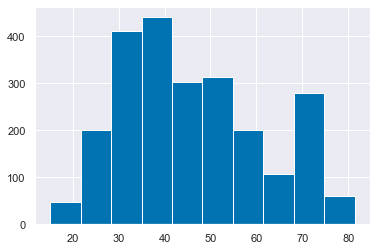

In [307]:
pd.Series(age_pred).hist()

In [313]:
age_pred = pd.Series(age_pred,index=age.index).round()
age.loc[age.isnull()] = age_pred.loc[age.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","age"] = age

In [ ]:
### housing vars

In [316]:
housing = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","housing_det"].copy()

In [317]:
housing.value_counts()

# accept that NA is some special situation and ignore that, but try to impute the DKs

mask = housing=="DK"

MORT       716
RENT-LA    697
OWN        532
RENT-PR    386
DK          18
NA          16
Name: housing_det, dtype: int64

In [319]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","housing_det"] = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","housing_det"].replace("DK",np.nan).replace("NA",np.nan)

In [323]:
housing.value_counts(dropna=False)

MORT       716
RENT-LA    697
OWN        532
RENT-PR    386
DK          18
NA          16
Name: housing_det, dtype: int64

In [327]:
# (housing=="DK").sum()

In [326]:
mask = housing=="DK"
mask.sum()

18

ACC: 0.75,  F1: 0.75


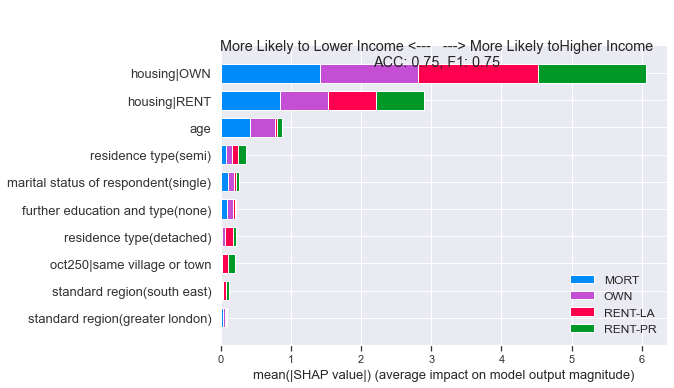

In [328]:
ge = "1974_oct"
harm_vars = ["wt","age","housing_det","harmonised_voted","inc_det","housing"]
target_var = "housing_det"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = ["Lower Income","Higher Income"]
var_stub = "housing_det"
min_features = 10
drop_vars = ['oct187a']

alg = get_xgboost_alg(classification_problem=True)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds==0].index)
drop_vars.remove("wt")
drop_vars.remove(var_stub)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=True,alg=alg,multi_class_target=True)

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
# use fitted algorithm to predict values
housing_pred = alg.predict(df_pred[train_columns])
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [333]:
housing.loc[mask] = housing_pred[mask]

In [337]:
# f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","housing"][mask]

## looks good!

f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","housing_det"] = housing.replace("NA",np.nan)

In [338]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","housing_det"].value_counts(dropna=False)

MORT       725
RENT-LA    700
OWN        537
RENT-PR    387
NaN         16
Name: housing_det, dtype: int64

In [ ]:
## votes - replace DKs

In [340]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote"].value_counts()

LAB    830
CON    704
LIB    352
DNV    347
DK      63
SNP     56
OTH      7
PC       6
Name: vote, dtype: int64

In [342]:
vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote"].copy()
mask = (vote_complete=="DK")
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote_complete"] = vote_complete.replace("DK",np.nan)

ACC: 0.93,  F1: 0.93


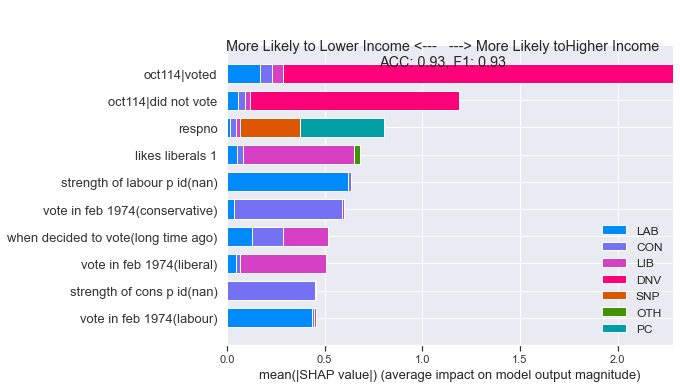

In [391]:
ge = "1974_oct"
harm_vars = ["wt","age","housing_det","vote_complete","inc"]
target_var = "vote_complete"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = ["Lower Income","Higher Income"]
var_stub = "vote_complete"
min_features = 10
drop_vars = ['oct115','oct112', # basic vote vars
             'oct115a','oct115b','oct115c', # vars for 'if you voted con/lab'
             'oct119','oct119a','oct119b','oct119c','oct119d'] # same for 'voted for libs'


alg = get_xgboost_alg(classification_problem=True)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<.25].index)
drop_vars.remove("wt")
drop_vars.remove(var_stub)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,alg=alg,multi_class_target=True)

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
vote_pred = alg.predict(df_pred[train_columns])
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

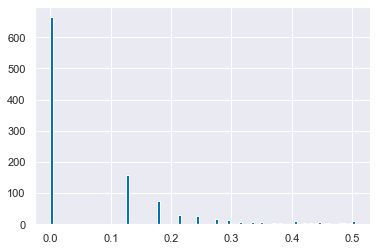

In [390]:
stds[stds<1].hist(bins=100)


In [392]:
pd.Series(vote_pred,index=vote_complete.index)[mask].value_counts()

CON    26
LAB    16
LIB    12
DNV     8
PC      1
dtype: int64

In [376]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote_complete"].value_counts()

LAB    830
CON    704
LIB    352
DNV    347
SNP     56
OTH      7
PC       6
Name: vote_complete, dtype: int64

In [393]:
temp = BES_df_list["1974_oct"][['oct124a','oct125','oct111','oct112','oct140','oct141']]
temp.columns = [BES_label_list["1974_oct"][x] for x in  temp.columns]
temp["pred"] = vote_pred
temp[mask].head(50)

vote in feb 1974   vote in 1970 trust conservatives      trust labour  \
68       did not vote         labour    some of the time  some of the time   
101      conservative  cant remember             usually           usually   
149     cant remember  cant remember    some of the time  some of the time   
182     cant remember  cant remember    some of the time           usually   
202     cant remember  cant remember    some of the time  some of the time   
246     cant remember  cant remember             usually           usually   
254      conservative   conservative                 NaN               NaN   
258     cant remember  cant remember    some of the time  some of the time   
260     cant remember  cant remember    some of the time  some of the time   
300     cant remember   conservative    some of the time  some of the time   
305     cant remember   did not vote    some of the time           usually   
383     cant remember  cant remember    some of the time  some of the time   
428      conservative   conservative                 NaN               NaN   
459     cant remember   did not vote              rarely            rarely   
463      conservative   conservative                 NaN               NaN   
513     cant remember   did not vote             usually  some of the time   
551     cant remember  cant remember    some of the time           usually   
623     cant remember   did not vote    some of the time  some of the time   
668      did not vote   did not vote             usually            rarely   
746      did not vote   conservative    some of the time  some of the time   
747     cant remember  cant remember    some of the time  some of the time   
803               NaN            NaN                 NaN               NaN   
840      conservative   conservative    some of the time            rarely   
855     cant remember  cant remember             usually  some of the time   
865      conservative         labour    some of the time  some of the time   
934     cant remember  cant remember    some of the time  some of the time   
935      did not vote   conservative    some of the time  some of the time   
1110          liberal          other    some of the time            rarely   
1121    cant remember  cant remember    some of the time  some of the time   
1131    cant remember  cant remember             usually           usually   
1151    cant remember  cant remember    some of the time  some of the time   
1155           labour   did not vote              rarely  some of the time   
1198    cant remember   did not vote    some of the time  some of the time   
1199    cant remember  cant remember    some of the time  some of the time   
1271          liberal   did not vote                 NaN               NaN   
1307    cant remember  cant remember    some of the time  some of the time   
1314    cant remember         labour    some of the time  some of the time   
1327    cant remember  cant remember             usually            rarely   
1365    cant remember   did not vote             usually  some of the time   
1370     conservative   conservative                 NaN               NaN   
1421    cant remember   did not vote             usually  some of the time   
1434     conservative   conservative    some of the time  some of the time   
1514    cant remember  cant remember             usually           usually   
1560    cant remember  cant remember    some of the time            rarely   
1571    cant remember  cant remember    some of the time  some of the time   
1585     conservative   conservative             usually           usually   
1588     did not vote   conservative             usually  some of the time   
1675           labour         labour             usually           usually   
1713    cant remember  cant remember    some of the time            rarely   
1754     did not vote   conservative              rarely            rarely   

     conservative mark out

In [383]:
{k:v for k,v in BES_label_list["1974_oct"].items() if "libs thought of" in v}

{'oct119d': 'libs thought of other party.'}

In [394]:
# BES_df_list["1974_oct"]["oct508"].value_counts()

In [397]:
vote_complete = vote_complete.replace("DK",np.nan)
vote_complete.loc[vote_complete.isnull()] = pd.Series(vote_pred,index=vote_complete.index).loc[vote_complete.isnull()]

f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote_complete"] = vote_complete

In [398]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote_complete"].value_counts(dropna=False)

LAB    846
CON    730
LIB    364
DNV    355
SNP     56
PC       7
OTH      7
Name: vote_complete, dtype: int64

In [ ]:
## inc

In [412]:
# BES_df_list["1974_oct"]["oct212"].value_counts()
inc = BES_df_list["1974_oct"]["oct212"].replace("7",np.nan).replace("8",np.nan).astype('category').cat.codes.replace(-1,np.nan)
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","inc_det"] = inc
mask = inc.isnull()

In [411]:
# f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","inc_det"].index,inc.index

MSE: 3.60, MAE: 1.41, EV: 0.61, R2: 0.61


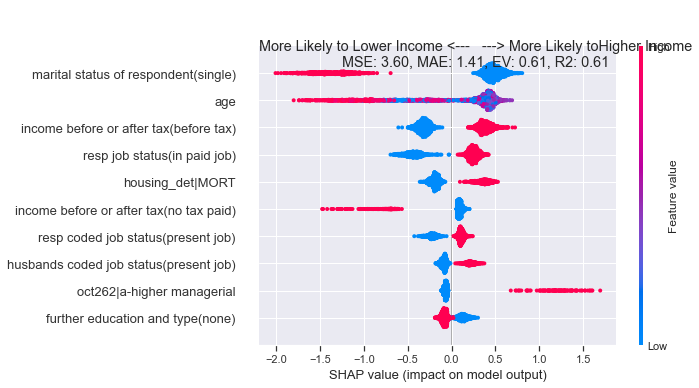

<Figure size 1152x720 with 0 Axes>

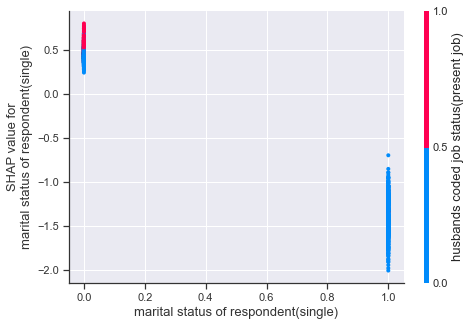

<Figure size 1152x720 with 0 Axes>

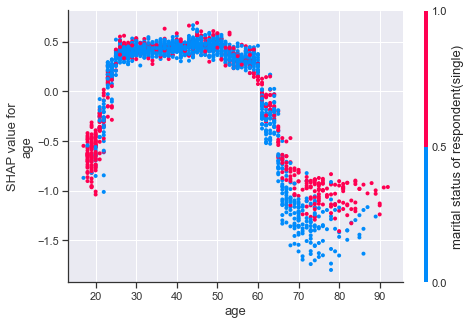

<Figure size 1152x720 with 0 Axes>

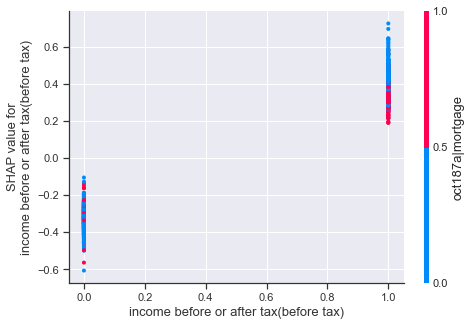

<Figure size 1152x720 with 0 Axes>

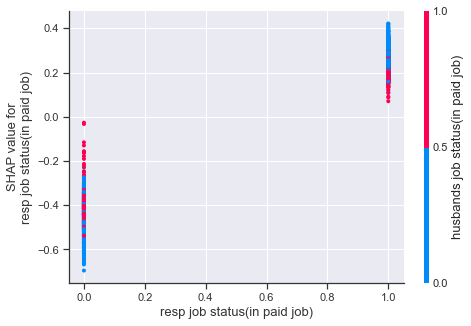

<Figure size 1152x720 with 0 Axes>

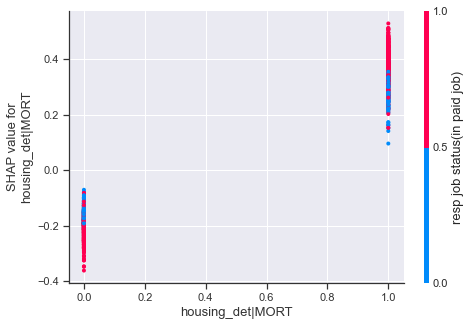

<Figure size 1152x720 with 0 Axes>

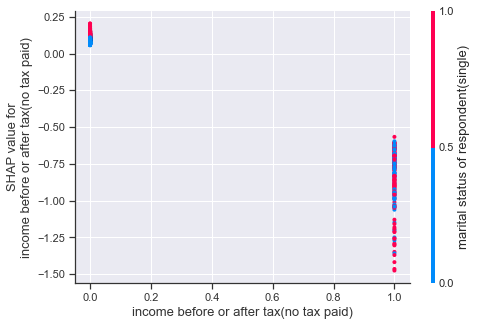

<Figure size 1152x720 with 0 Axes>

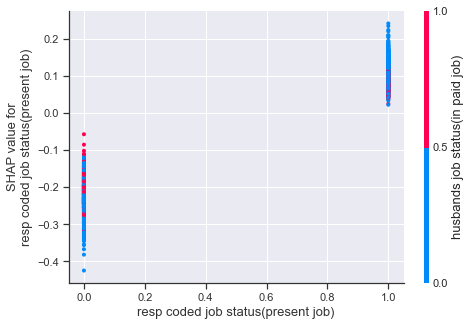

<Figure size 1152x720 with 0 Axes>

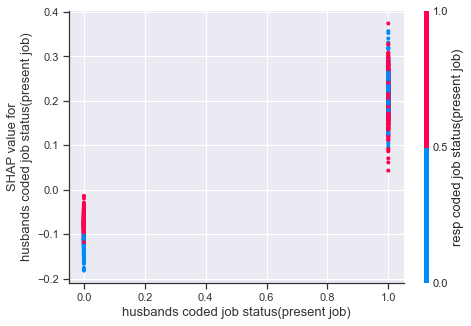

<Figure size 1152x720 with 0 Axes>

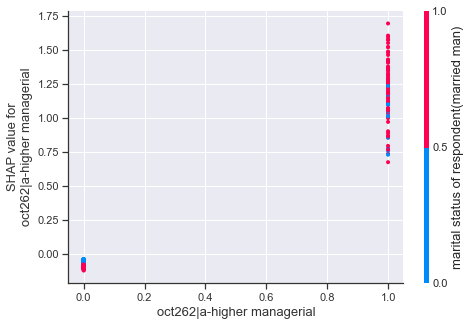

<Figure size 1152x720 with 0 Axes>

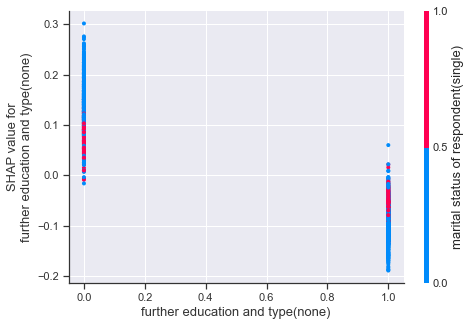

In [414]:
ge = "1974_oct"
harm_vars = ["wt","age","housing_det","harmonised_voted","inc_det"]
target_var = "inc_det"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = ["Lower Income","Higher Income"]
var_stub = "inc_det"
min_features = 10
drop_vars = ["oct212"]
drop_std_thresh = 0

alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars]
drop_vars.remove("wt")
drop_vars.remove(var_stub)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True,alg=alg)

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=True)
# use fitted algorithm to predict values
inc_pred = alg.predict(df_pred[train_columns])
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [420]:
inc_pred = pd.Series(inc_pred,index=inc.index).round()
inc.loc[inc.isnull()] = inc_pred.loc[inc.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","inc_det"] = inc

In [418]:
# inc_pred.hist()

In [419]:
# inc.hist()

In [421]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct"].isnull().sum()

dataset                    0
uid                        0
housing_det               16
housing                    0
inc                      348
vote                       0
year                       0
wt                         0
age                        0
vote_simple                7
bloc                       0
birth_year                10
harmonised_voted           0
inc_det                    0
vote_complete              0
vote_complete_simple    2365
bloc_complete           2365
turnout_complete        2365
dtype: int64

In [ ]:
## just do vote_complete/simple/bloc/turnout

In [424]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote_complete"].value_counts()

LAB    846
CON    730
LIB    364
DNV    355
SNP     56
PC       7
OTH      7
Name: vote_complete, dtype: int64

In [422]:
vote_simple = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote_complete"].replace(simple_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote_complete_simple"] = vote_simple
vote_simple.value_counts(dropna=False)

LAB    846
CON    730
LD     364
DNV    355
SNP     56
DK       7
PC       7
Name: vote_complete, dtype: int64

In [423]:
bloc_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote_complete_simple"].replace(bloc_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","bloc_complete"] = bloc_complete
bloc_complete.value_counts(dropna=False)

Left-Lib      1273
Right-Auth     730
Neither        355
NaN              7
Name: vote_complete_simple, dtype: int64

In [425]:
turnout_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","vote_complete"].replace(turnout_dict)
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct","turnout_complete"] = turnout_complete
turnout_complete.value_counts(dropna=False)

VOTED    2010
DNV       355
Name: vote_complete, dtype: int64

In [427]:
# f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_oct"].isnull().sum()

In [428]:
f2f_harmonised.to_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')